In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [39]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

paorder=['PRO','ALT']
papallete=[PRO_COLOR, ALT_COLOR]

In [7]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [8]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [9]:
df = pd.read_pickle('CCPA.pkl.gz')

In [10]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [11]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [12]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [13]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [14]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [15]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day       FL
5           e1, 10A         e1    10A  MIT0604  DE  Co_Culture  -10  0.37325
6           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -9  0.44400
7           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -8  0.69700
8           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -7  0.95000
9           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -6  1.20300

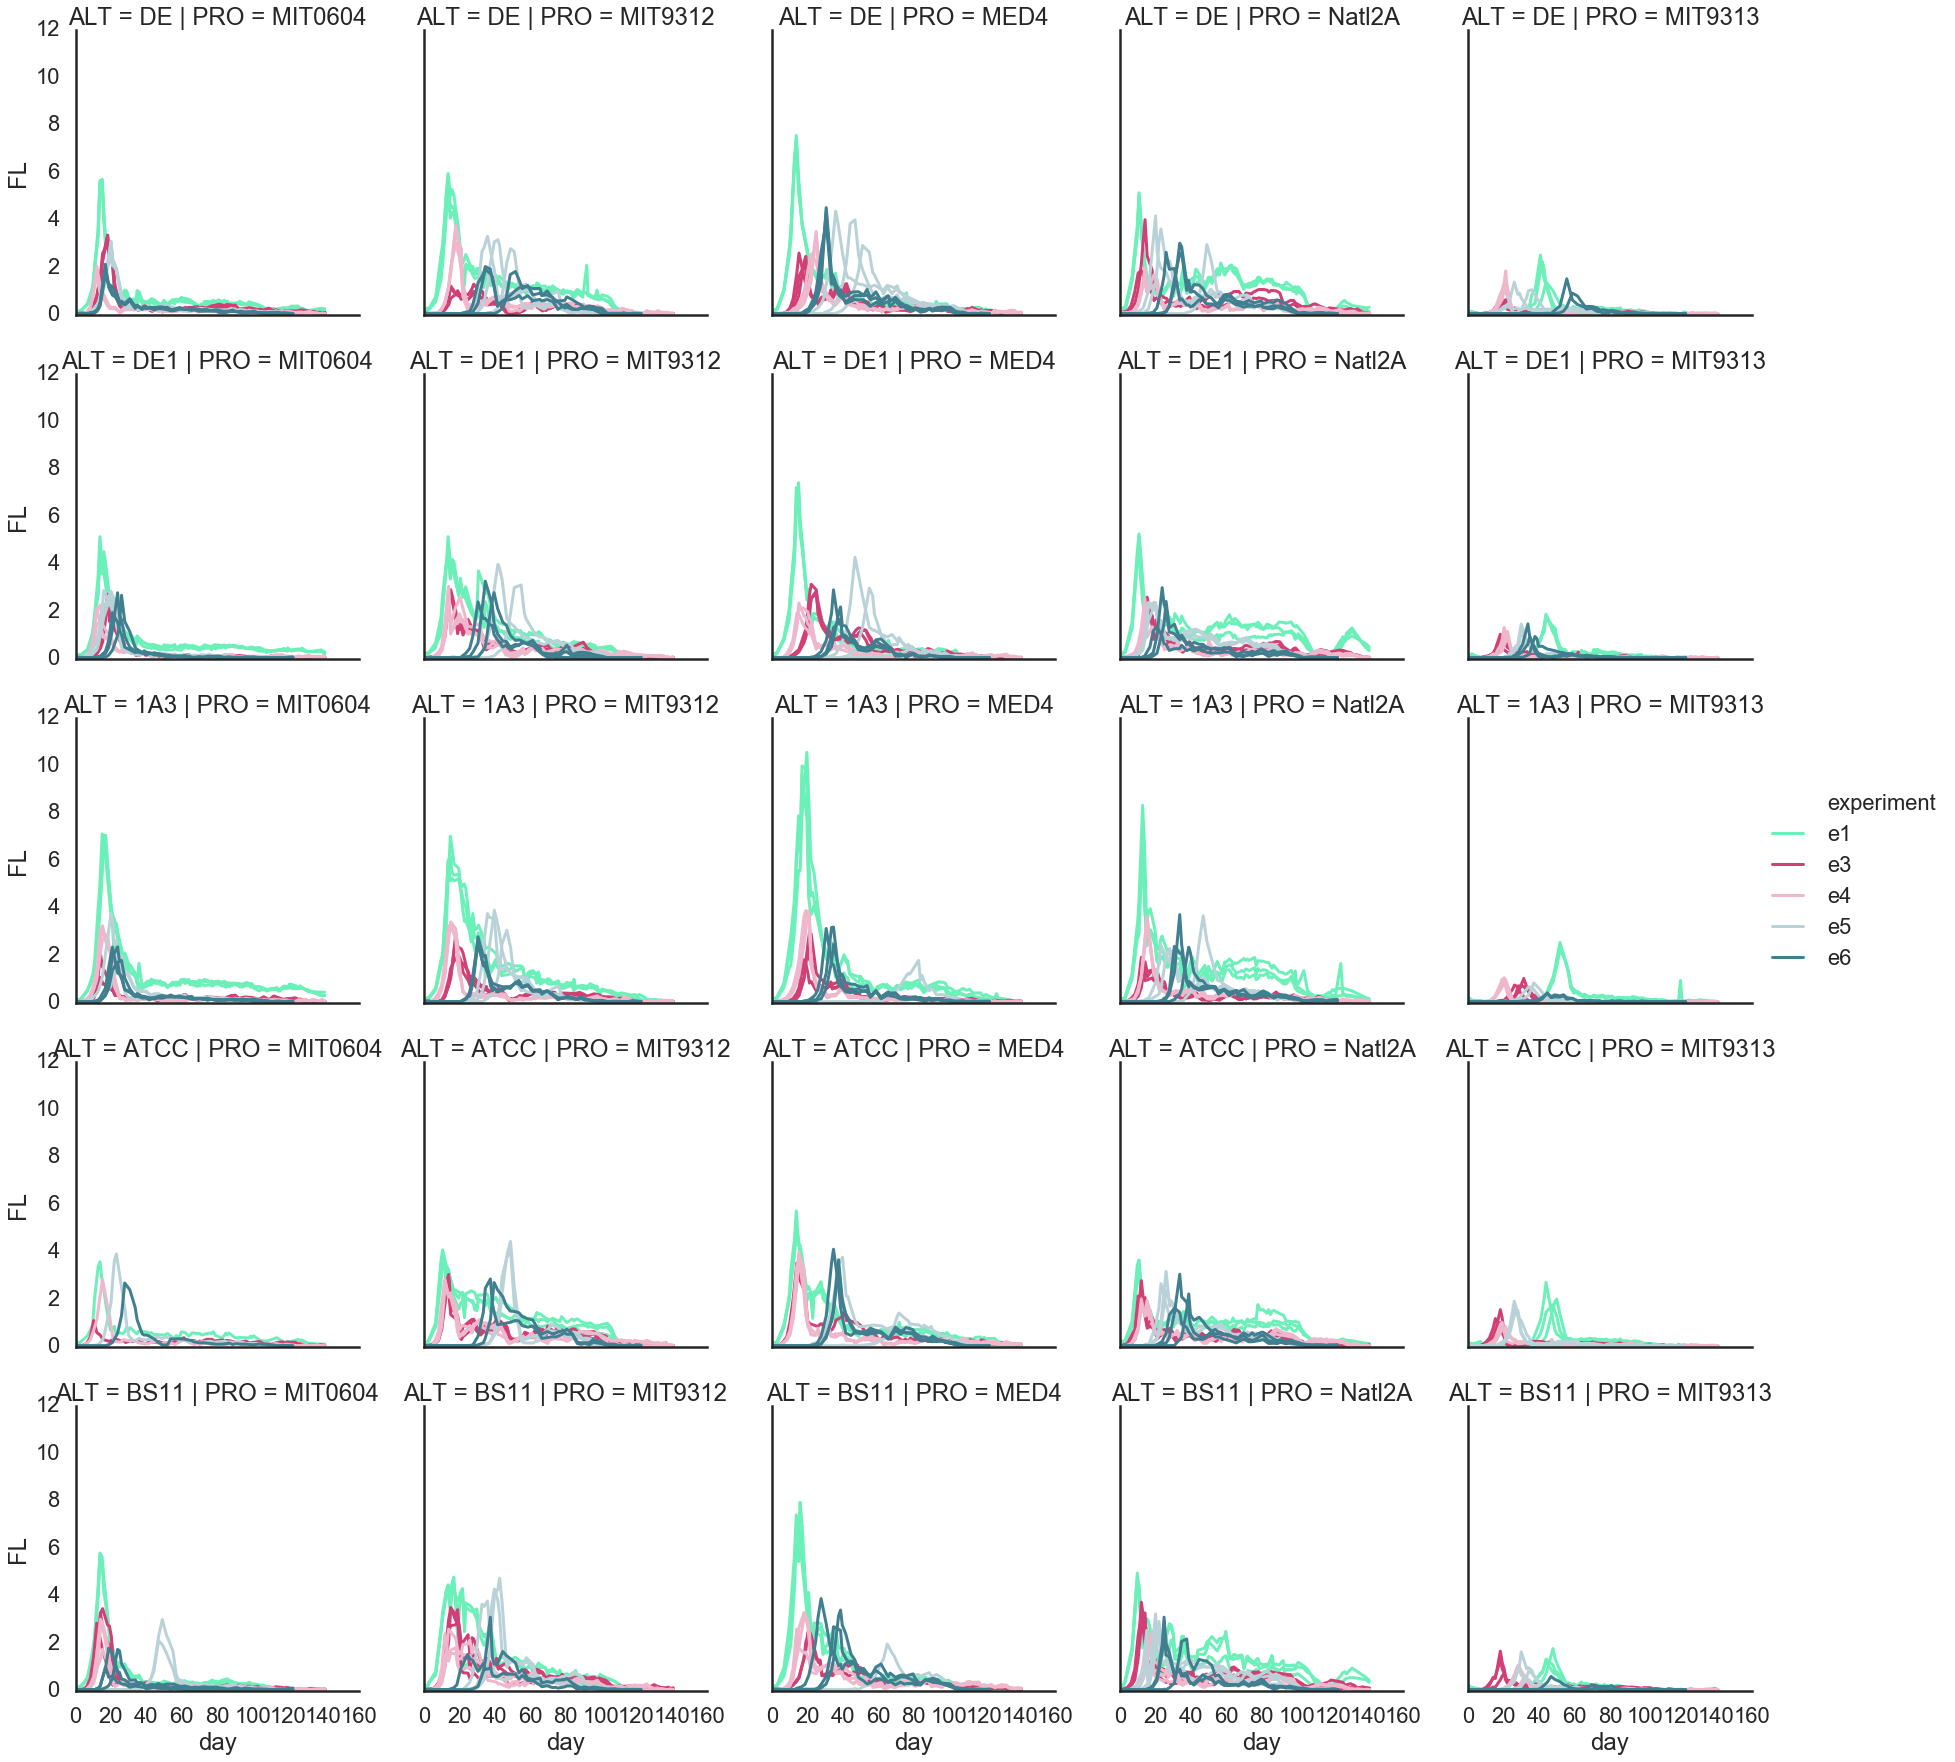

In [16]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

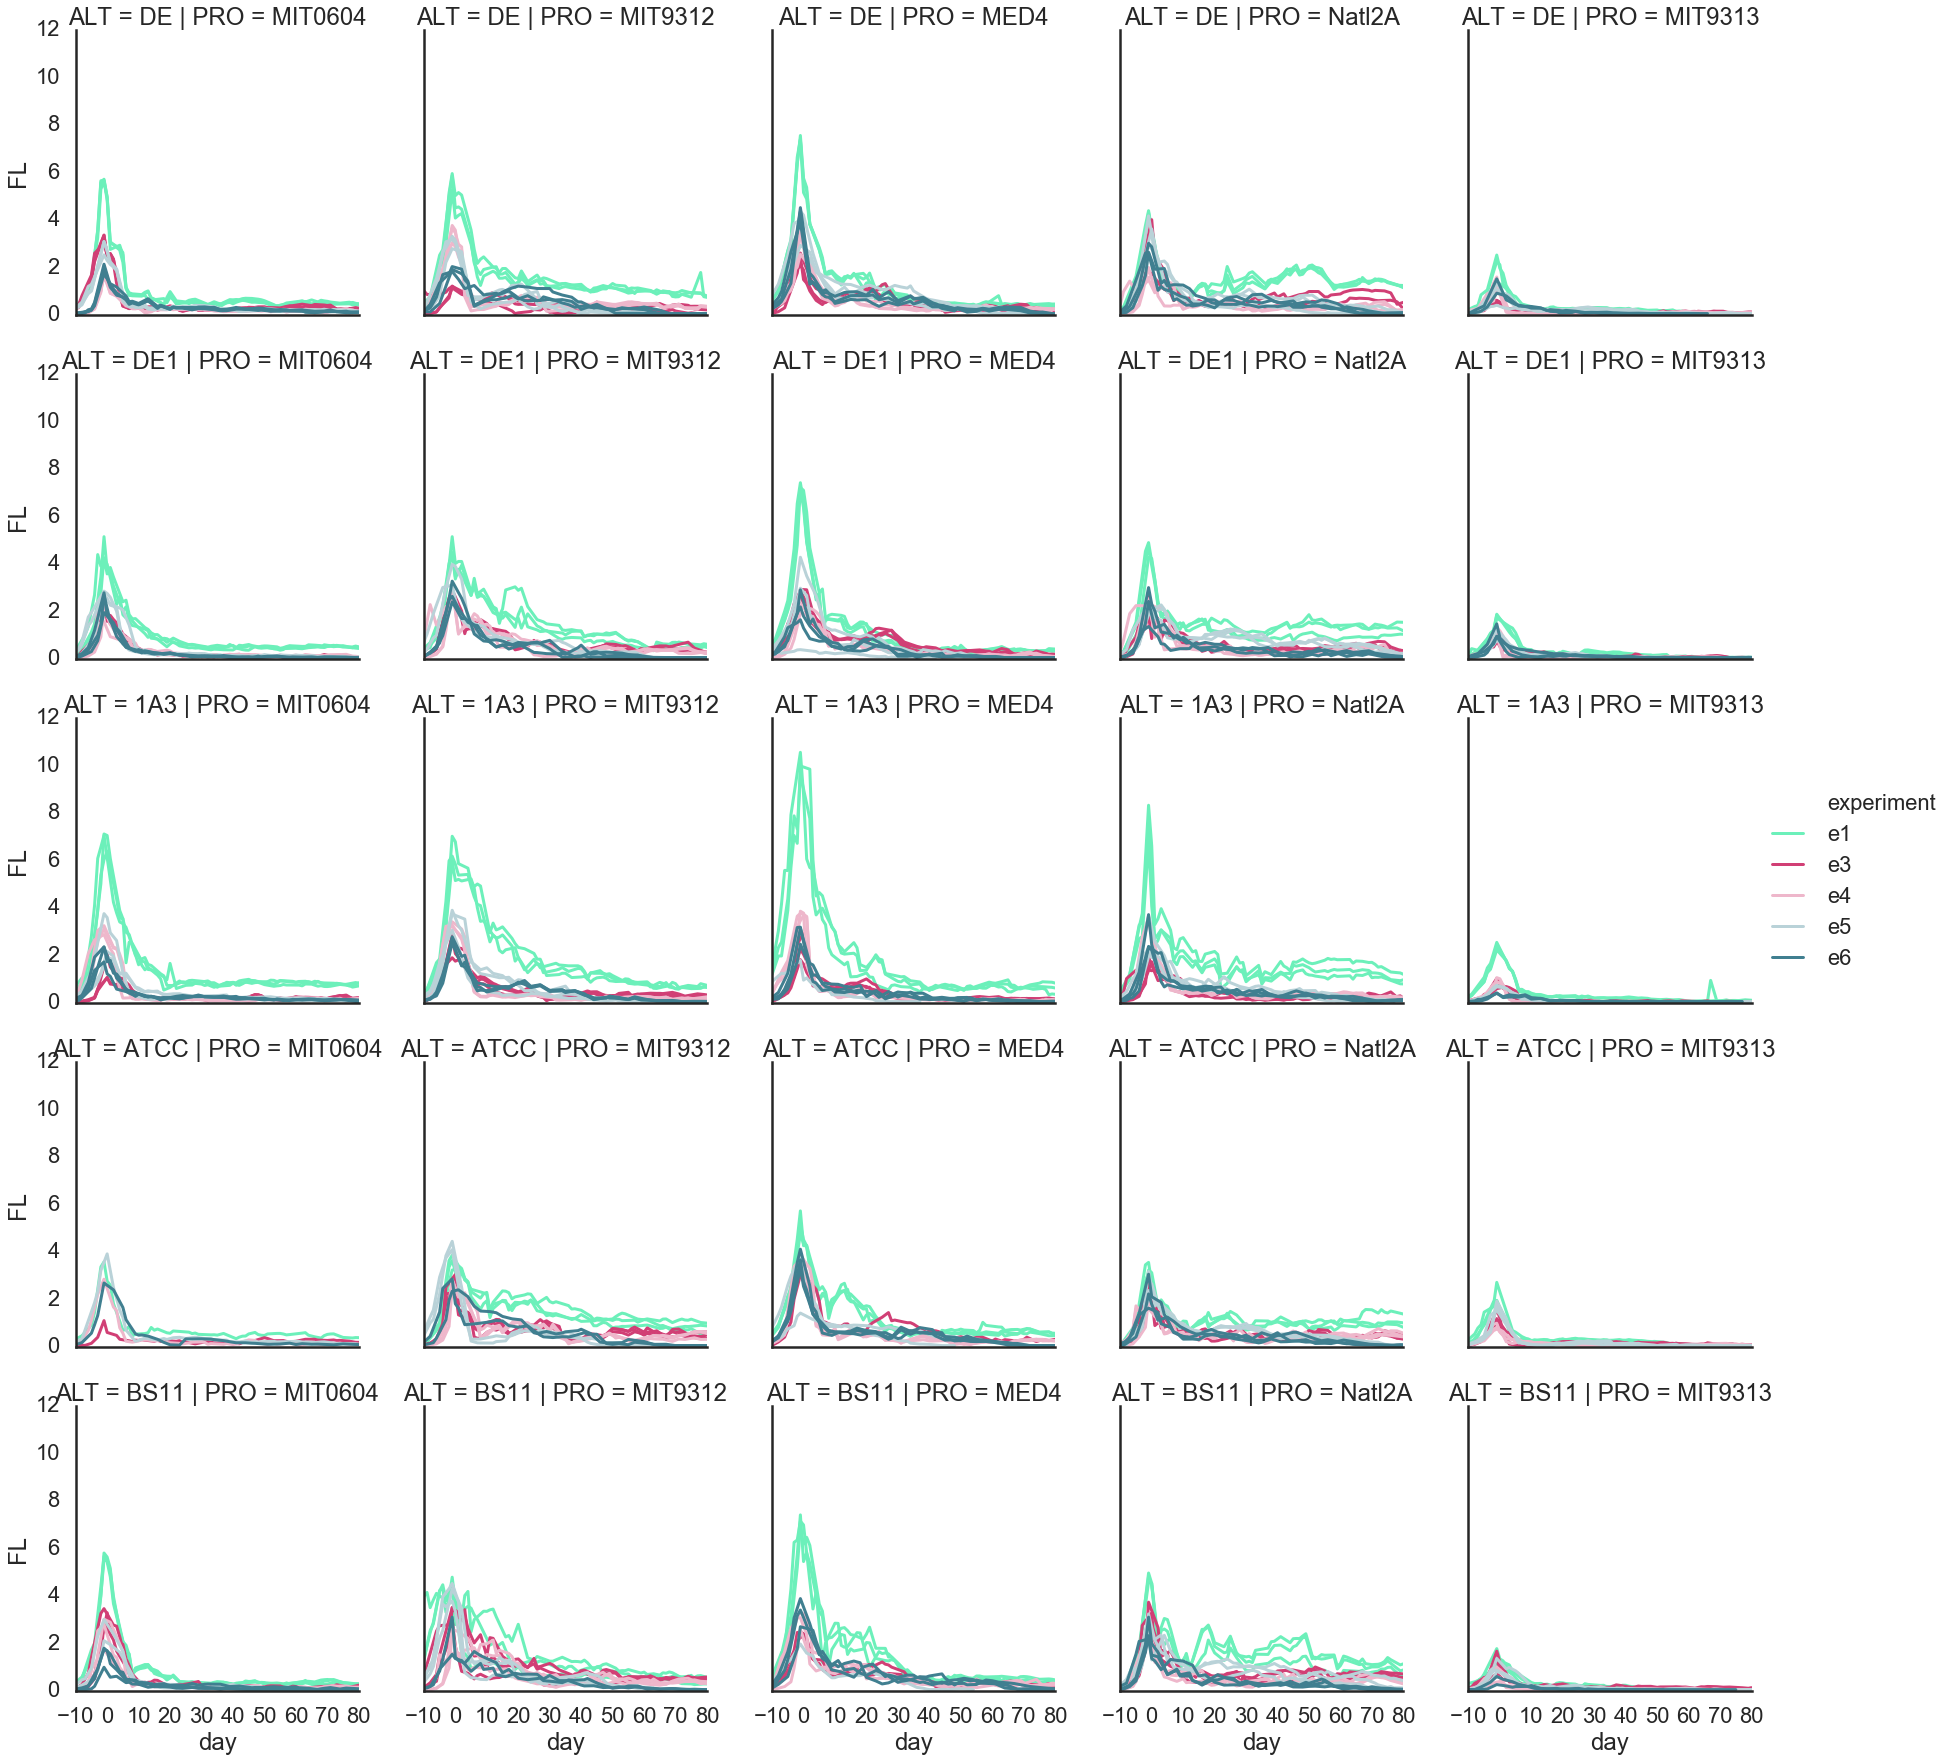

In [17]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

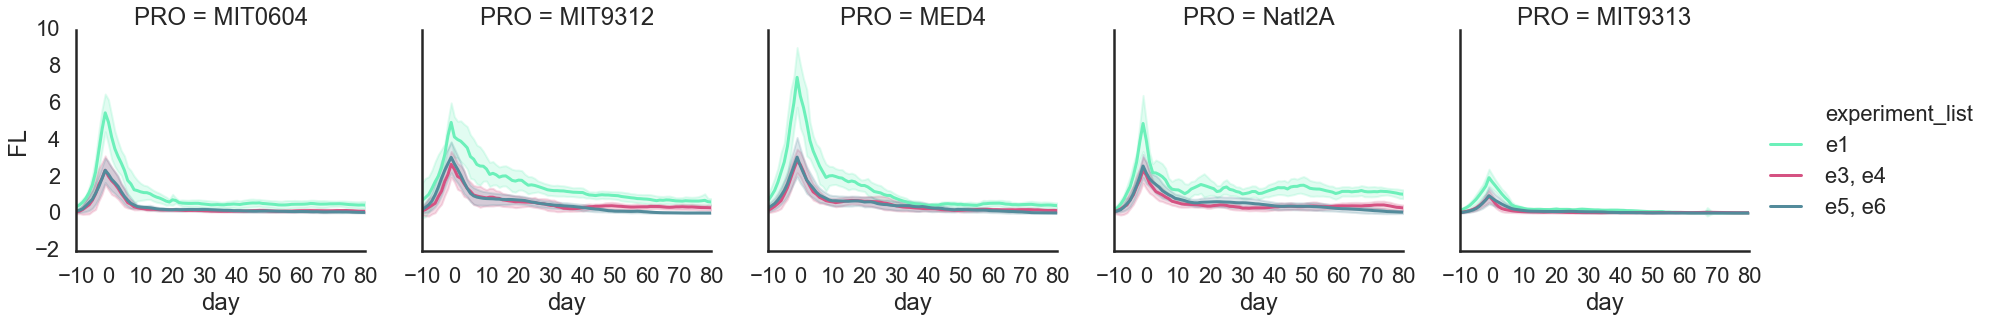

In [18]:
ds['experiment_list'] = ''
ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'
ds.loc[ds.experiment.isin(['e1']), 'experiment_list'] = 'e1'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', #aspect=1.8,
            x='day', y='FL', kind='line', col='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                col_order=porder,
               )
#g.set(yscale='log')

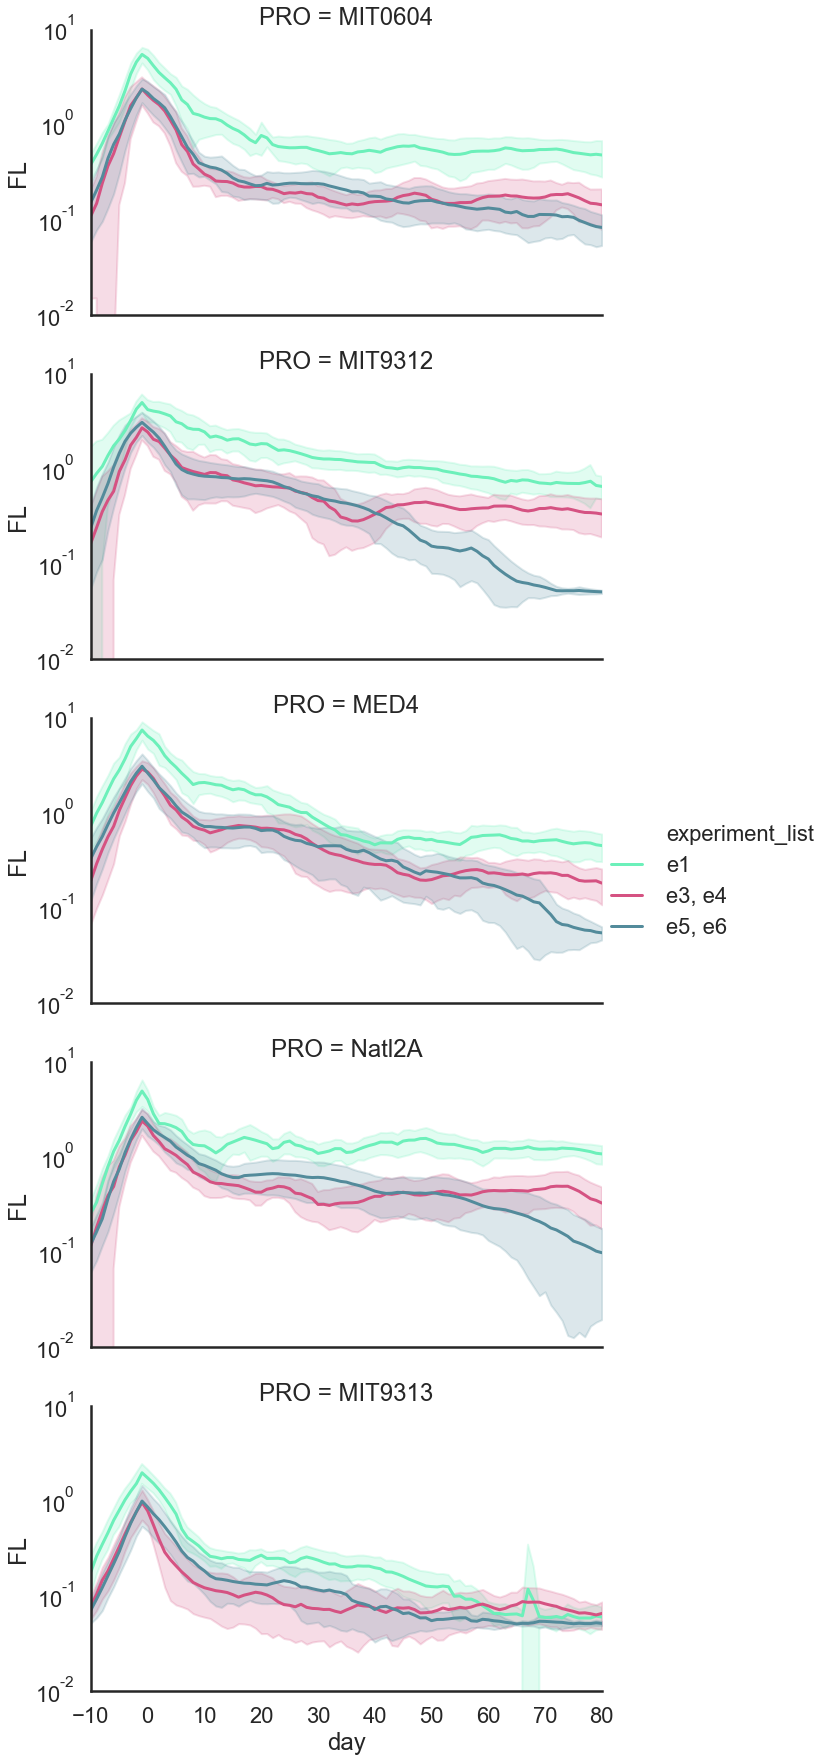

In [19]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', row='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                row_order=porder
               )
g.set(yscale='log')

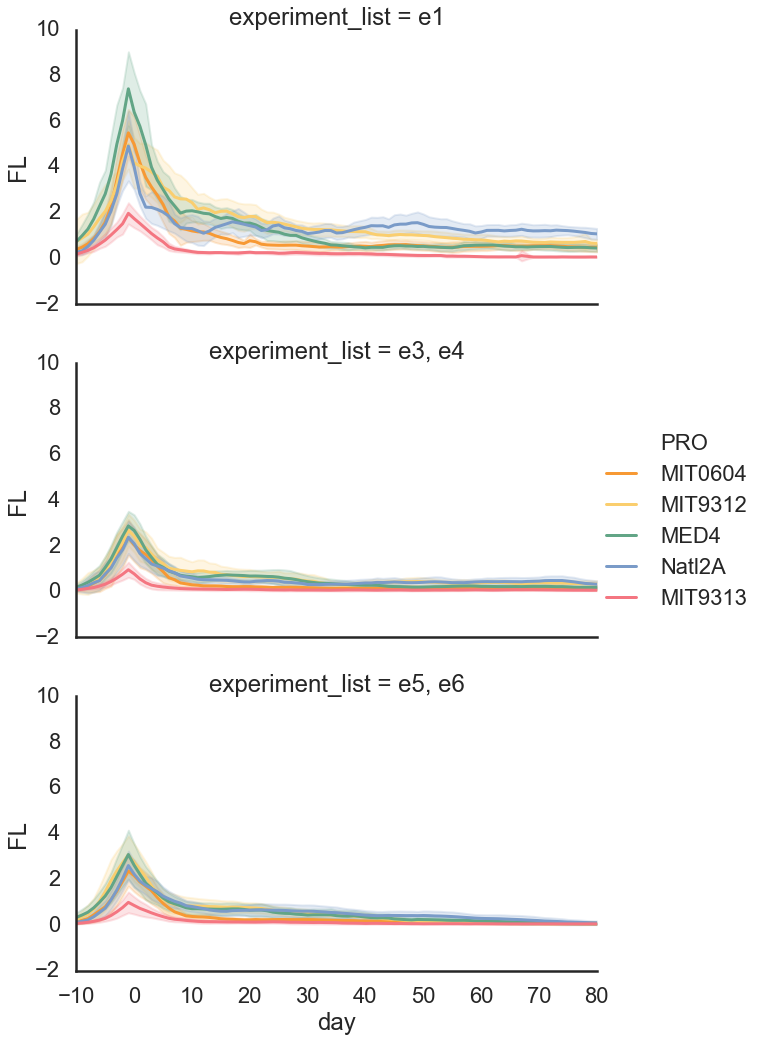

In [20]:
g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
#g.set(yscale='log')

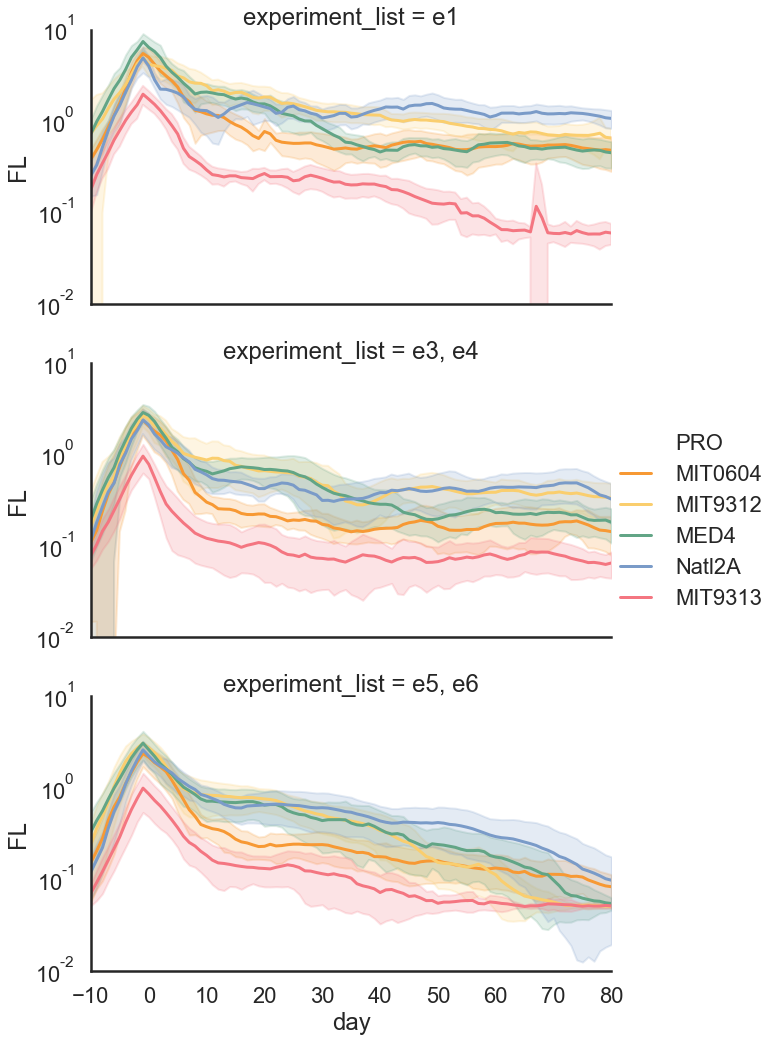

In [21]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
g.set(yscale='log')


In [22]:
ds['decline'] = ds['FL']

In [23]:
ds1 = ds.loc[ds.experiment.isin(['e1'])]
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [24]:
ds34.head()

experiment_sample experiment sample      PRO ALT     culture  day  \
10344           e3, 10A         e3    10A  MIT0604  DE  Co_Culture  -10   
10345           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -9   
10346           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -8   
10347           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -7   
10348           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -6   

          FL experiment_list  decline  
10344  0.299          e3, e4    0.299  
10345  0.381          e3, e4    0.381  
10346  0.693          e3, e4    0.693  
10347  0.959          e3, e4    0.959  
10348  1.225          e3, e4    1.225

# cross validation

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_score
value_col = 'FL'
y_col = 'PRO'
train_df = ds1
test_df = ds34
X_train = cp.experiments2X(ds1, cumsummode=False, value_col=value_col)
X_test = cp.experiments2X(ds34, cumsummode=False, value_col=value_col)
metadf_train = cp.get_meta(train_df)
metadf_test = cp.get_meta(test_df)

metadf_train.index = metadf_train.experiment_sample
metadf_test.index = metadf_test.experiment_sample

y_train = metadf_train[y_col]
y_test = metadf_test[y_col]
#clf = cp.forest_classifier(X=X_train, y=y_train)
scaledX = StandardScaler().fit_transform(X_train)
clf = RandomForestClassifier(n_estimators=100, oob_score=True,
                             )

pro_scores = cross_val_score(clf, scaledX, y_train, cv=10,  )
print("Accuracy: %0.2f (+/- %0.2f)" % (pro_scores.mean(), pro_scores.std() * 2))


Accuracy: 0.92 (+/- 0.17)


In [26]:
pro_scores

array([1.        , 0.8       , 0.9       , 1.        , 0.88888889,
       0.8       , 1.        , 1.        , 1.        , 0.8       ])

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
value_col = 'FL'
y_col = 'ALT'
train_df = ds1
test_df = ds34
X_train = cp.experiments2X(ds1, cumsummode=False, value_col=value_col)
X_test = cp.experiments2X(ds34, cumsummode=False, value_col=value_col)
metadf_train = cp.get_meta(train_df)
metadf_test = cp.get_meta(test_df)

metadf_train.index = metadf_train.experiment_sample
metadf_test.index = metadf_test.experiment_sample

y_train = metadf_train[y_col]
y_test = metadf_test[y_col]
#clf = cp.forest_classifier(X=X_train, y=y_train)
scaledX = StandardScaler().fit_transform(X_train)
clf = RandomForestClassifier(n_estimators=100, oob_score=True,
                             )

alt_scores = cross_val_score(clf, scaledX, y_train, cv=10, )
print("Accuracy: %0.2f (+/- %0.2f)" % (alt_scores.mean(), alt_scores.std() * 2))


Accuracy: 0.62 (+/- 0.58)


In [28]:
alt_scores

array([0.5       , 0.6       , 0.        , 0.33333333, 0.55555556,
       0.6       , 0.8       , 0.8       , 1.        , 1.        ])

(0, 1)

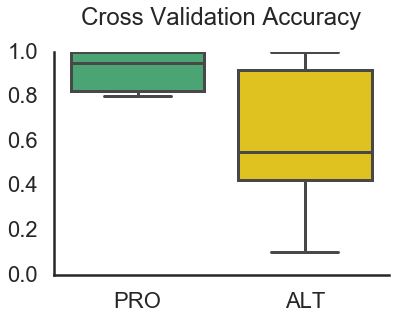

In [59]:
sns.set(style='white', context='poster', #font_scale=1.7
       )
sns.boxplot(x=['PRO', 'ALT'], y=[pro_scores, alt_scores], palette=papallete )
plt.title('Cross Validation Accuracy', y=1.1)
sns.despine()
plt.ylim(0,1)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_score
def compute_cross_val_scores(df, experiment, value_col, y_col):
    train_df = df.loc[df.experiment.isin([experiment])]
    X_train = cp.experiments2X(train_df, cumsummode=False, value_col=value_col)
    metadf_train = cp.get_meta(train_df)
    metadf_train.index = metadf_train.experiment_sample
    y_train = metadf_train[y_col]
    scaledX = StandardScaler().fit_transform(X_train)
    clf = RandomForestClassifier(n_estimators=100, oob_score=True,)
    scores = cross_val_score(clf, scaledX, y_train, cv=10,  )
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return pd.DataFrame({'Accuracy': scores, 'experiment':experiment, 'type':y_col})    


In [31]:
scores_list = [compute_cross_val_scores(ds, e, 'FL', y) for e in eorder for y in ['PRO', 'ALT']]

Accuracy: 0.95 (+/- 0.17)
Accuracy: 0.64 (+/- 0.48)
Accuracy: 0.82 (+/- 0.26)
Accuracy: 0.52 (+/- 0.54)
Accuracy: 0.89 (+/- 0.29)
Accuracy: 0.65 (+/- 0.24)
Accuracy: 0.81 (+/- 0.35)
Accuracy: 0.34 (+/- 0.52)


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.82 (+/- 0.37)


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.44 (+/- 0.51)


In [32]:
scores_df = pd.concat(scores_list)

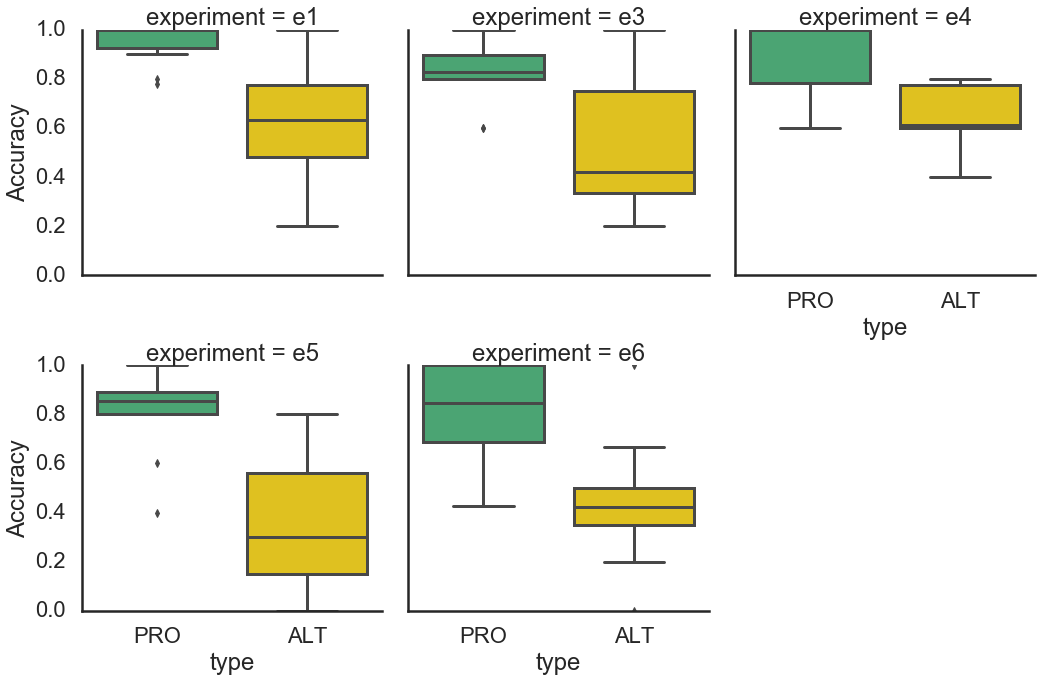

In [41]:
sns.set_context('poster')
sns.catplot(data=scores_df, x='type', col='experiment', y='Accuracy', col_wrap=3, 
            col_order=eorder, kind='box', order=paorder, palette=papallete)

Text(0.5, 1, 'Cross Validation Accuracy')

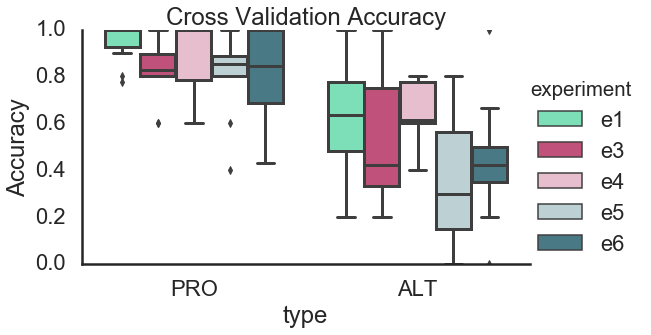

In [56]:
sns.set_context('poster')
sns.catplot(data=scores_df, x='type', hue='experiment', y='Accuracy', hue_order=eorder, 
            kind='box', palette=epallete, aspect=1.6)
plt.title('Cross Validation Accuracy')

Text(0.5, 1, 'Cross Validation Accuracy')

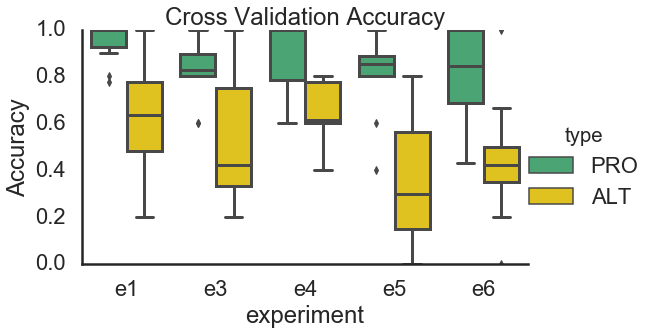

In [50]:
sns.set_context('poster')
sns.catplot(data=scores_df, hue='type', x='experiment', y='Accuracy', order=eorder, 
            kind='box', hue_order=paorder, palette=papallete, aspect=1.6)
plt.title('Cross Validation Accuracy')

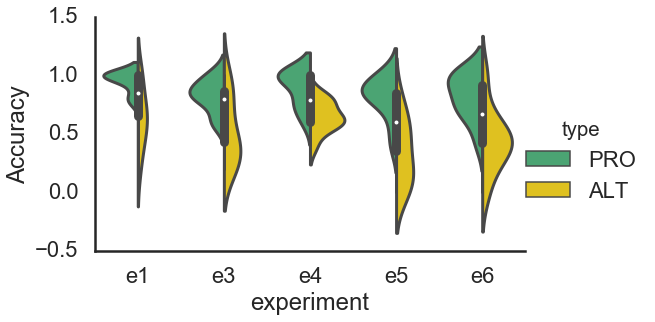

In [48]:
sns.set_context('poster')
sns.catplot(data=scores_df, hue='type', x='experiment', y='Accuracy', order=eorder, 
            kind='violin', split=True, hue_order=paorder, palette=papallete, aspect=1.6)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
value_col = 'FL'
y_col = 'ALT'
train_df = ds1
test_df = ds34
X_train = cp.experiments2X(ds1, cumsummode=False, value_col=value_col)
X_test = cp.experiments2X(ds34, cumsummode=False, value_col=value_col)
metadf_train = cp.get_meta(train_df)
metadf_test = cp.get_meta(test_df)

metadf_train.index = metadf_train.experiment_sample
metadf_test.index = metadf_test.experiment_sample

y_train = metadf_train[y_col]
y_test = metadf_test[y_col]
#clf = cp.forest_classifier(X=X_train, y=y_train)
scaledX = StandardScaler().fit_transform(X_train)
clf = RandomForestClassifier(n_estimators=100, oob_score=True,
                             )

alt_scores = cross_val_score(clf, scaledX, y_train, cv=10, )
print("Accuracy: %0.2f (+/- %0.2f)" % (alt_scores.mean(), alt_scores.std() * 2))


Accuracy: 0.61 (+/- 0.59)


In [36]:
alt_scores

array([0.5       , 0.5       , 0.1       , 0.33333333, 0.66666667,
       0.6       , 0.4       , 1.        , 1.        , 1.        ])

(0, 1)

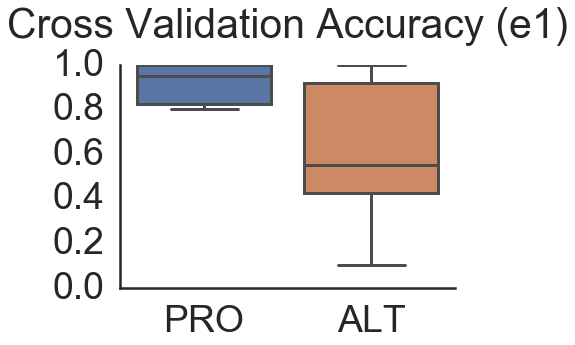

In [37]:
sns.set(style='white', context='poster', font_scale=1.7)
sns.boxplot(x=['PRO', 'ALT'], y=[pro_scores, alt_scores] )
plt.title('Cross Validation Accuracy (e1)', y=1.1)
sns.despine()
plt.ylim(0,1)

In [38]:
sns.set(style='white', context='poster', font_scale=1.7)
pslist = [f'test_f1_{p}' for p in porder]
sns.boxplot(x=pslist, y=[pro_scores[i] for i in pslist] )
plt.title('Cross Validation F1 macro', y=1.1)
sns.despine()
plt.ylim(0,1)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
sns.set(style='white', context='poster', font_scale=1.7)
aslist = [f'test_f1_{a}' for a in aorder]
sns.boxplot(x=aslist, y=[alt_scores[i] for i in aslist] )
plt.title('Cross Validation F1 macro', y=1.1)
sns.despine()
plt.ylim(0,1)

In [ ]:
pro_scores

In [70]:
res, _y_list, _clf_list, _features_list = cp.compare_models2(ds34, ds56, 
               value_col_list=['FL'], 
               y_col_list=['PRO', 'ALT'], 
               repetitions=30,
               return_y=True)


PRO_FL
train score 1.0
oob score 0.8705035971223022
train score

C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 1.0
oob score 0.8705035971223022
train score 1.0
oob score 0.8705035971223022
train score 1.0
oob score 0.8345323741007195


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8705035971223022
train score 1.0
oob score 0.8489208633093526
train score 1.0
oob score 0.8705035971223022
train score 1.0
oob score 0.8633093525179856
train score 1.0
oob score 0.8920863309352518


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8633093525179856
train score 1.0
oob score 0.8633093525179856


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8776978417266187
train score 1.0
oob score 0.8633093525179856
train score 1.0
oob score 0.8776978417266187
train score 1.0
oob score 0.8848920863309353
train score 1.0
oob score 0.8705035971223022
train score 1.0
oob score 0.8705035971223022


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8705035971223022
train score 1.0
oob score 0.8489208633093526
train score 1.0
oob score 0.8633093525179856


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.9136690647482014


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8776978417266187
train score 1.0
oob score 0.8776978417266187
train score 1.0
oob score 0.8633093525179856
train score 1.0
oob score 0.8705035971223022


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8848920863309353
train score 1.0
oob score 0.8561151079136691


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.8776978417266187
train score 1.0
oob score 0.8848920863309353
train score 1.0
oob score 0.9064748201438849
ALT_FL
train score 1.0
oob score 0.60431654676259


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5539568345323741


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5467625899280576
train score 1.0
oob score 0.5539568345323741


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5035971223021583
train score 1.0
oob score 0.5251798561151079
train score 1.0
oob score 0.5035971223021583


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5323741007194245


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5611510791366906
train score 1.0
oob score 0.49640287769784175


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5323741007194245
train score 1.0
oob score 0.5827338129496403


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5755395683453237


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5611510791366906


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5899280575539568


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5683453237410072


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.6258992805755396


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5611510791366906
train score 1.0
oob score 0.5539568345323741
train score 1.0
oob score 0.5467625899280576


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5683453237410072


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5683453237410072


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5323741007194245
train score 1.0
oob score 0.5611510791366906


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5827338129496403
train score 1.0
oob score 0.5035971223021583


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5683453237410072
train score 1.0
oob score 0.5251798561151079


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5971223021582733


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train score 1.0
oob score 0.5683453237410072


C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
stats1to34_df = pd.DataFrame.from_records(res)


In [72]:
stats1to34_df.nlargest(5,'f1_test')

model  n_features  orig_n_features  accuracy_train  precision_train  \
27  PRO_FL          91               91             1.0              1.0   
9   PRO_FL          91               91             1.0              1.0   
17  PRO_FL          91               91             1.0              1.0   
24  PRO_FL          91               91             1.0              1.0   
25  PRO_FL          91               91             1.0              1.0   

    recall_train  f1_train support_train  accuracy_test  precision_test  \
27           1.0       1.0          None       0.488189        0.616103   
9            1.0       1.0          None       0.488189        0.615265   
17           1.0       1.0          None       0.488189        0.616032   
24           1.0       1.0          None       0.480315        0.606575   
25           1.0       1.0          None       0.488189        0.624839   

    recall_test   f1_test support_test value_col y_col  
27     0.488189  0.425264         None        FL   PRO  
9      0.488189  0.424330         None        FL   PRO  
17     0.488189  0.423263         None        FL   PRO  
24     0.480315  0.415542         None        FL   PRO  
25     0.488189  0.414908         None        FL   PRO

In [74]:
stats1to34_df.loc[stats1to34_df.y_col == 'PRO']. nlargest(5,'f1_test')

model  n_features  orig_n_features  accuracy_train  precision_train  \
27  PRO_FL          91               91             1.0              1.0   
9   PRO_FL          91               91             1.0              1.0   
17  PRO_FL          91               91             1.0              1.0   
24  PRO_FL          91               91             1.0              1.0   
25  PRO_FL          91               91             1.0              1.0   

    recall_train  f1_train support_train  accuracy_test  precision_test  \
27           1.0       1.0          None       0.488189        0.616103   
9            1.0       1.0          None       0.488189        0.615265   
17           1.0       1.0          None       0.488189        0.616032   
24           1.0       1.0          None       0.480315        0.606575   
25           1.0       1.0          None       0.488189        0.624839   

    recall_test   f1_test support_test value_col y_col  
27     0.488189  0.425264         None        FL   PRO  
9      0.488189  0.424330         None        FL   PRO  
17     0.488189  0.423263         None        FL   PRO  
24     0.480315  0.415542         None        FL   PRO  
25     0.488189  0.414908         None        FL   PRO

In [75]:
stats1to34_df.loc[stats1to34_df.y_col == 'ALT']. nlargest(5,'f1_test')

model  n_features  orig_n_features  accuracy_train  precision_train  \
40  ALT_FL          91               91             1.0              1.0   
39  ALT_FL          91               91             1.0              1.0   
38  ALT_FL          91               91             1.0              1.0   
41  ALT_FL          91               91             1.0              1.0   
36  ALT_FL          91               91             1.0              1.0   

    recall_train  f1_train support_train  accuracy_test  precision_test  \
40           1.0       1.0          None       0.291339        0.286118   
39           1.0       1.0          None       0.291339        0.305213   
38           1.0       1.0          None       0.283465        0.261374   
41           1.0       1.0          None       0.283465        0.271587   
36           1.0       1.0          None       0.291339        0.273063   

    recall_test   f1_test support_test value_col y_col  
40     0.291339  0.273759         None        FL   ALT  
39     0.291339  0.269489         None        FL   ALT  
38     0.283465  0.259512         None        FL   ALT  
41     0.283465  0.254157         None        FL   ALT  
36     0.291339  0.254126         None        FL   ALT

In [18]:
train1_df_orig, test1_df_orig = cp.split_train_test(ds1,test_size=0.4)
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [19]:
test1_df_orig.groupby(['PRO', 'ALT'])['sample'].unique()

PRO      ALT 
MED4     1A3           [1B]
         ATCC         [21C]
         BS11         [16C]
         DE            [6A]
         DE1          [11A]
MIT0604  1A3           [5A]
         BS11    [20A, 20B]
         DE           [10C]
         DE1          [15C]
MIT9312  1A3           [3A]
         ATCC    [23B, 23C]
         BS11         [18C]
         DE            [8A]
         DE1     [13A, 13C]
MIT9313  1A3           [2A]
         ATCC    [22A, 22B]
         BS11         [17B]
         DE            [7B]
         DE1          [12A]
Natl2A   1A3           [4C]
         ATCC         [24A]
         BS11         [19B]
         DE        [9A, 9C]
         DE1          [14C]
Name: sample, dtype: object

In [20]:
train1_df = train1_df_orig
test1_df = test1_df_orig
train34_df = train34_df_orig
test34_df = test34_df_orig
train56_df = train56_df_orig
test56_df = test56_df_orig

In [21]:
train1_df.shape, test1_df.shape, train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

((3913, 9), (2639, 9), (7553, 9), (5096, 9), (6762, 9), (4467, 9))

In [29]:
train34_df.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'day', 'FL', 'experiment_list', 'decline'],
      dtype='object')

In [90]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 0.8192771084337349
train score 1.0
oob score 0.7951807228915663
train score 1.0
oob score 0.8313253012048193
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8433734939759037
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8554216867469879
train score 1.0
oob score 0.7831325301204819
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8192771084337349
train score 1.0
oob score 0.8433734939759037
train score 1.0
oob score 0.8192771084337349
train score 1.0
oob score 0.8072289156626506
train score 1.0
oob score 0.8313253012048193
train score 1.0
oob score 0.8192771084337349
train score 1.0
oob score 0.8192771084337349
train score 1.0
oob score 0.8192771084337349
train score 1.0
oob score 0.8313253012048193
train score 1.0
oob score 0.8072289156626506
tra

In [91]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 0.7105263157894737
train score 1.0
oob score 0.7105263157894737
train score 1.0
oob score 0.6842105263157895
train score 1.0
oob score 0.7368421052631579
train score 1.0
oob score 0.6578947368421053
train score 1.0
oob score 0.6973684210526315
train score 1.0
oob score 0.7105263157894737
train score 1.0
oob score 0.7631578947368421
train score 1.0
oob score 0.7236842105263158
train score 1.0
oob score 0.6710526315789473
train score 1.0
oob score 0.6973684210526315
train score 1.0
oob score 0.7105263157894737
train score 1.0
oob score 0.75
train score 1.0
oob score 0.7631578947368421
train score 1.0
oob score 0.7105263157894737
train score 1.0
oob score 0.75
train score 1.0
oob score 0.6842105263157895
train score 1.0
oob score 0.7236842105263158
train score 1.0
oob score 0.6710526315789473
train score 1.0
oob score 0.7105263157894737
train score 1.0
oob score 0.75
train score 1.0
oob score 0.7368421052631579
train score 1.0
oob score 0.7236842105263158


In [92]:
stats1_list = []
y1_list = []
clf1_list = []
features1_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train1_df, test1_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats1_list.extend(res)
y1_list.extend(_y_list)
clf1_list.extend(_clf_list)
features1_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 0.9069767441860465
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.9302325581395349
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.9069767441860465
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8837209302325582
train score 1.0
oob score 0.8372093023255814
trai

In [93]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)
stats1_df = pd.DataFrame.from_records(stats1_list)


In [94]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
3   0.798739       0.803922             1.0
28  0.797242       0.803922             1.0
29  0.783713       0.803922             1.0
14  0.777028       0.784314             1.0
26  0.776165       0.784314             1.0
19  0.772683       0.784314             1.0
16  0.764665       0.784314             1.0
21  0.755897       0.764706             1.0
25  0.754139       0.764706             1.0
13  0.754139       0.764706             1.0

In [95]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
3   0.911513       0.910714             1.0
1   0.911502       0.910714             1.0
12  0.910714       0.910714             1.0
15  0.910592       0.910714             1.0
4   0.893379       0.892857             1.0
11  0.892728       0.892857             1.0
7   0.892634       0.892857             1.0
28  0.890200       0.892857             1.0
5   0.875836       0.875000             1.0
13  0.875696       0.875000             1.0

In [96]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
25  0.965517       0.965517             1.0
9   0.965517       0.965517             1.0
18  0.965517       0.965517             1.0
22  0.965517       0.965517             1.0
16  0.965517       0.965517             1.0
14  0.965517       0.965517             1.0
13  0.965517       0.965517             1.0
11  0.965517       0.965517             1.0
21  0.965517       0.965517             1.0
8   0.965517       0.965517             1.0

In [97]:
idx34 = 25
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [98]:
y34_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred PRO_FL_y_pred_PRO   Type
experiment_sample                                                             
e3, 10B            MIT0604      MIT0604       MIT0604           MIT0604  Train
e3, 10C            MIT0604      MIT0604       MIT0604           MIT0604  Train
e3, 11A               MED4         MED4          MED4              MED4  Train
e3, 11B               MED4         MED4          MED4              MED4  Train
e3, 11C               MED4         MED4          MED4              MED4  Train

accuracy: 0.8571428571428571
              precision    recall  f1-score   support

        MED4       0.80      0.80      0.80        10
     MIT0604       0.77      1.00      0.87        10
     MIT9312       0.83      0.77      0.80        13
     MIT9313       1.00      1.00      1.00        11
      Natl2A       0.90      0.75      0.82        12

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



Text(0.5,1,'e3, e4, accuracy=0.86')

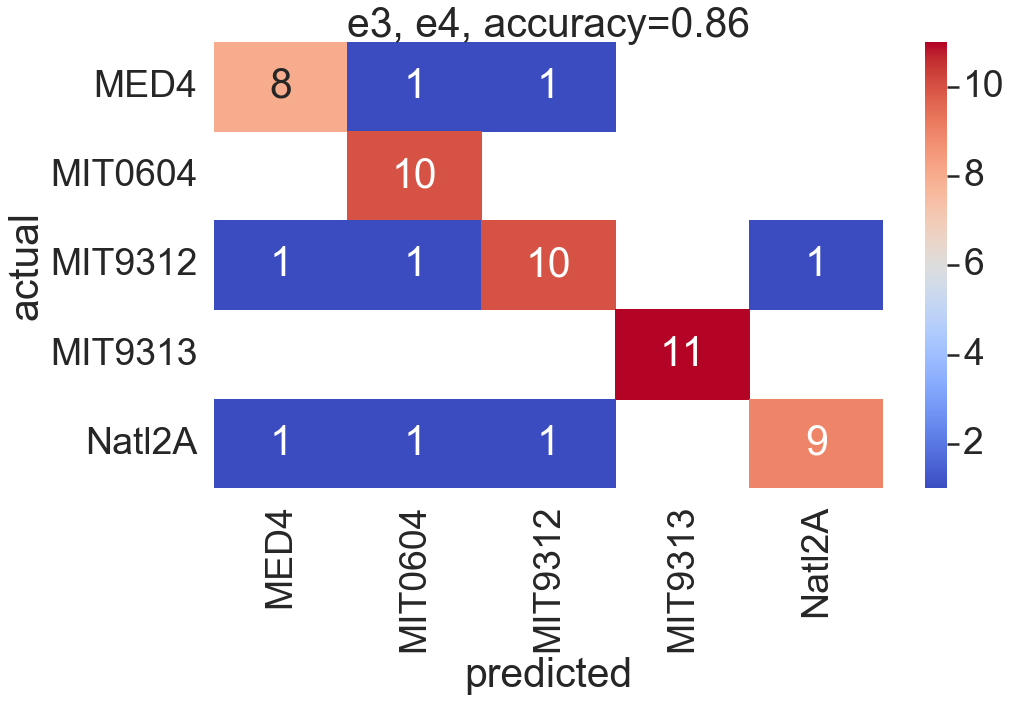

In [99]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')
    plt.title(f"e3, e4, accuracy={accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']):.2}")

Text(0.5,1,'e3 ,e4')

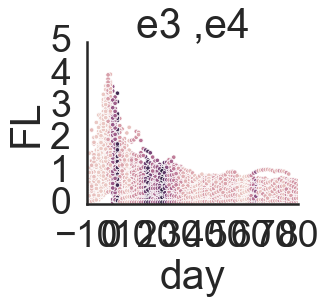

In [100]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)
plt.ylim(0,5)
plt.xlim(-10,80)
plt.title('e3 ,e4')

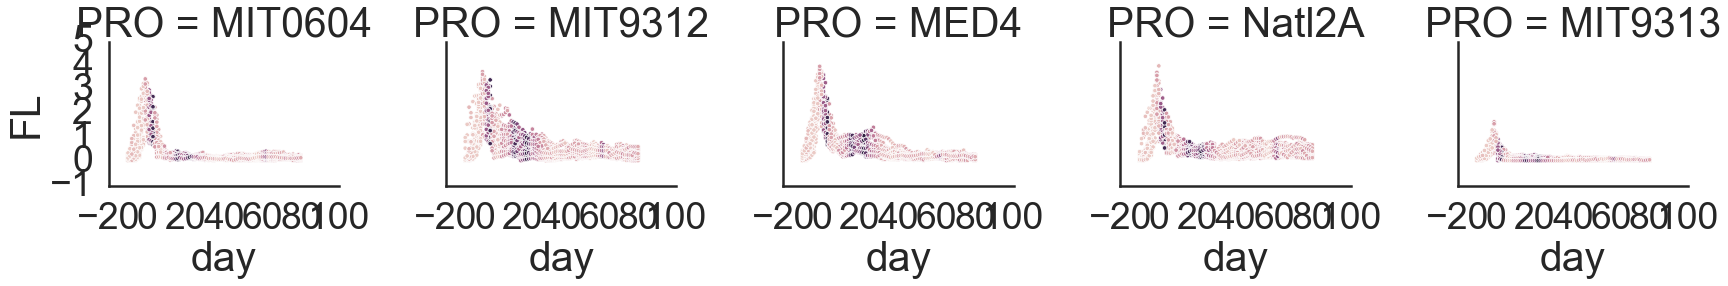

In [101]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

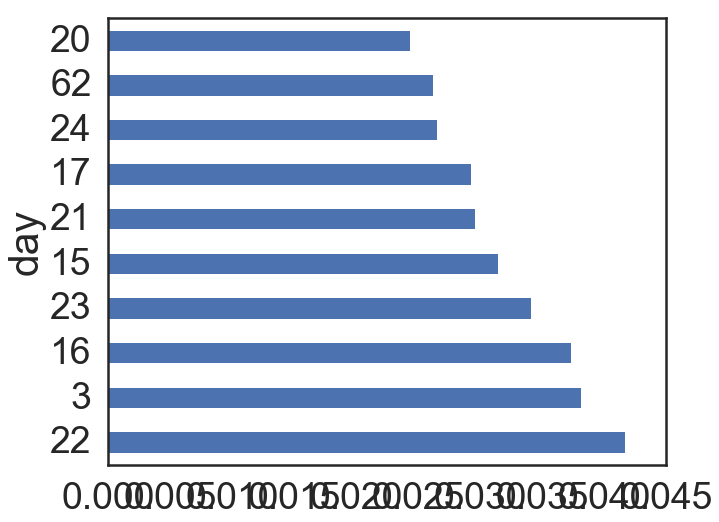

In [102]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [103]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
3   0.798739       0.803922             1.0
28  0.797242       0.803922             1.0
29  0.783713       0.803922             1.0
14  0.777028       0.784314             1.0
26  0.776165       0.784314             1.0
19  0.772683       0.784314             1.0
16  0.764665       0.784314             1.0
21  0.755897       0.764706             1.0
25  0.754139       0.764706             1.0
13  0.754139       0.764706             1.0

In [104]:
idx56 = 8
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [105]:
y56_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred PRO_FL_y_pred_PRO   Type
experiment_sample                                                             
e5, 10B            MIT0604      MIT0604       MIT0604           MIT0604  Train
e5, 10C            MIT0604      MIT0604       MIT0604           MIT0604  Train
e5, 11C               MED4         MED4          MED4              MED4  Train
e5, 12B            MIT9313      MIT9313       MIT9313           MIT9313  Train
e5, 13C            MIT9312      MIT9312       MIT9312           MIT9312  Train

accuracy: 0.7450980392156863
              precision    recall  f1-score   support

        MED4       0.67      0.36      0.47        11
     MIT0604       0.86      0.67      0.75         9
     MIT9312       0.80      0.80      0.80        10
     MIT9313       0.89      0.89      0.89         9
      Natl2A       0.63      1.00      0.77        12

    accuracy                           0.75        51
   macro avg       0.77      0.74      0.74        51
weighted avg       0.76      0.75      0.73        51



Text(0.5,1,'e5, e6, accuracy=0.75')

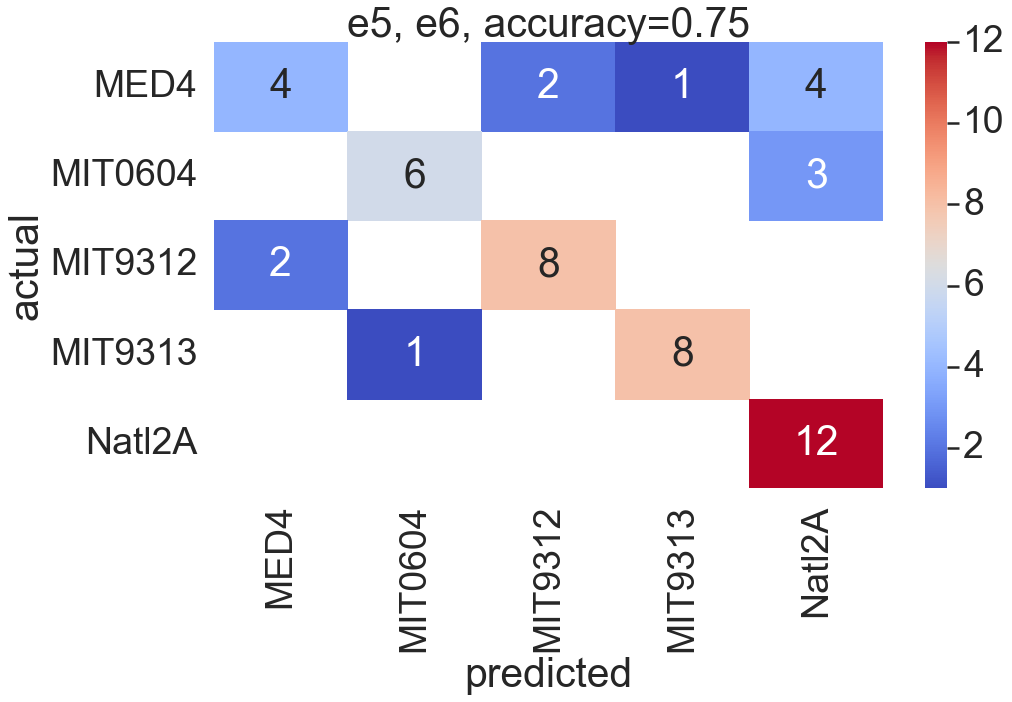

In [106]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')
    plt.title(f"e5, e6, accuracy={accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']):.2}")

Text(0.5,1,'e5, e6')

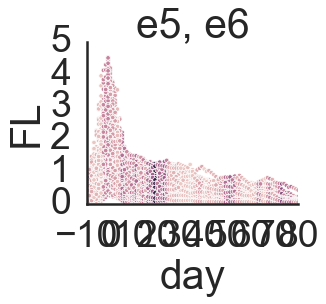

In [107]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)
plt.ylim(0,5)
plt.xlim(-10,80)

plt.title('e5, e6')

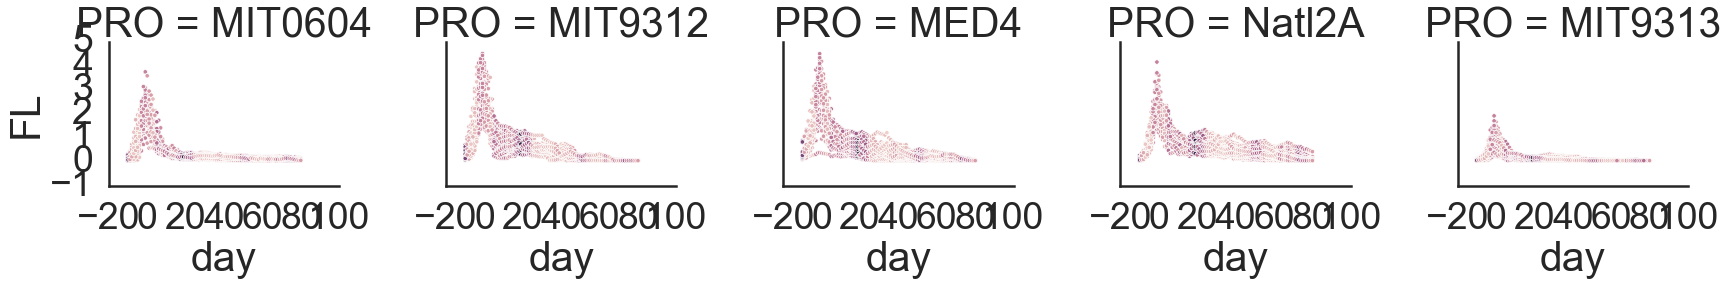

In [108]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

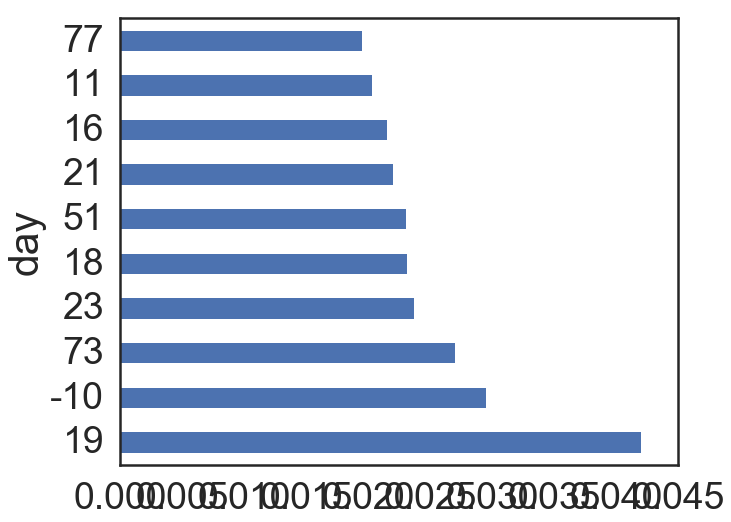

In [109]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [110]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
25  0.965517       0.965517             1.0
9   0.965517       0.965517             1.0
18  0.965517       0.965517             1.0
22  0.965517       0.965517             1.0
16  0.965517       0.965517             1.0
14  0.965517       0.965517             1.0
13  0.965517       0.965517             1.0
11  0.965517       0.965517             1.0
21  0.965517       0.965517             1.0
8   0.965517       0.965517             1.0

In [113]:
idx1 = 25
y1_df =  y1_list[idx1]
clf1 = clf1_list[idx1]
features1 = features1_list[idx1]

In [114]:
y1_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred PRO_FL_y_pred_PRO   Type
experiment_sample                                                             
e1, 10A            MIT0604      MIT0604       MIT0604           MIT0604  Train
e1, 10B            MIT0604      MIT0604       MIT0604           MIT0604  Train
e1, 11B               MED4         MED4          MED4              MED4  Train
e1, 11C               MED4         MED4          MED4              MED4  Train
e1, 12B            MIT9313      MIT9313       MIT9313           MIT9313  Train

accuracy: 0.9655172413793104
              precision    recall  f1-score   support

        MED4       1.00      1.00      1.00         5
     MIT0604       1.00      1.00      1.00         5
     MIT9312       1.00      0.86      0.92         7
     MIT9313       1.00      1.00      1.00         6
      Natl2A       0.86      1.00      0.92         6

    accuracy                           0.97        29
   macro avg       0.97      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29



Text(0.5,1,'e1, accuracy=0.97')

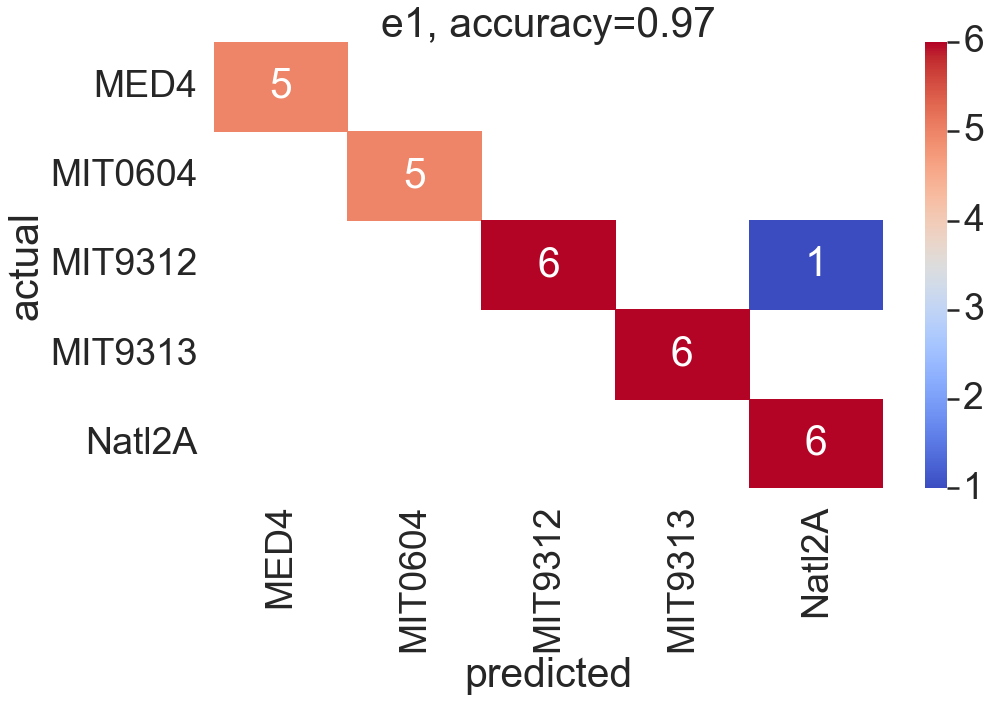

In [115]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y1_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')
    plt.title(f"e1, accuracy={accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']):.2}")

Text(0.5,1,'e1')

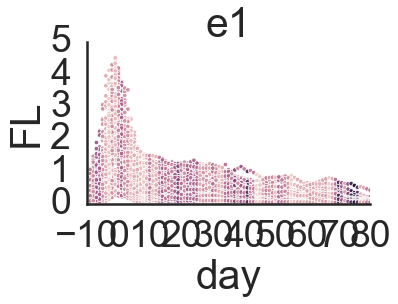

In [116]:
feature_importances1 = pd.DataFrame(clf1.feature_importances_,
                                   index = features1,
                                    columns=['importance'])
merge1df = ds56.merge(feature_importances1, left_on='day', right_index=True, how='left')
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, aspect=1.4)
plt.ylim(0,5)
plt.xlim(-10,80)
plt.title('e1')
#plt.title('FL per day (experiment 1) - colored by impotance')

Text(0.5,1,'FL per day (experiment 1) - sized by impotance')

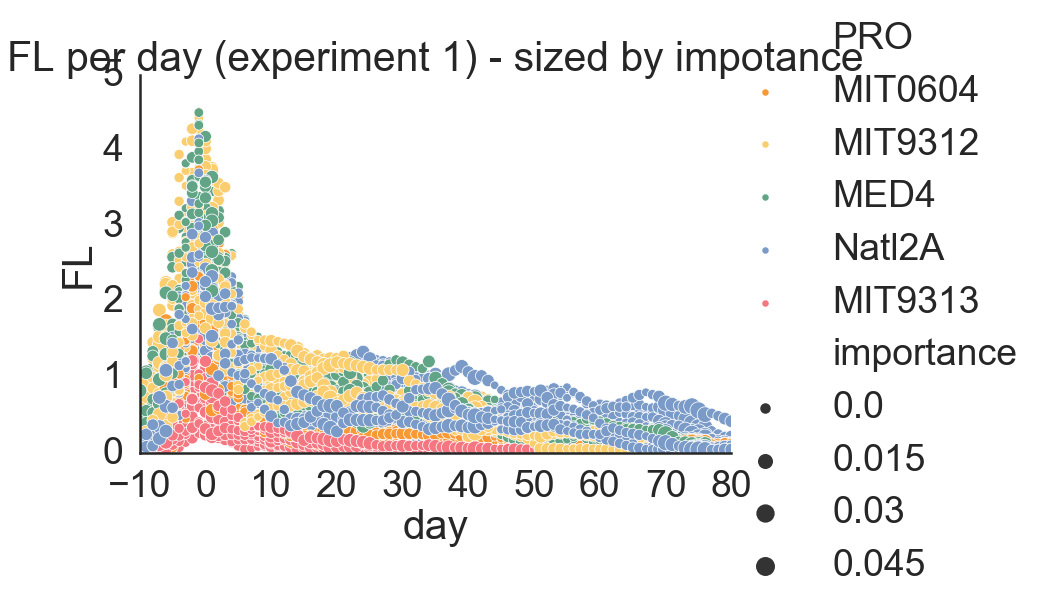

In [117]:
feature_importances1 = pd.DataFrame(clf1.feature_importances_,
                                   index = features1,
                                    columns=['importance'])
merge1df = ds56.merge(feature_importances1, left_on='day', right_index=True, how='left')
sns.relplot(data=merge1df, x='day', y='FL', size='importance', hue='PRO', 
            aspect=1.4, height=8,
            hue_order=porder, palette=ppallete,
           )
plt.ylim(0,5)
plt.xlim(-10,80)
plt.title('FL per day (experiment 1) - sized by impotance')

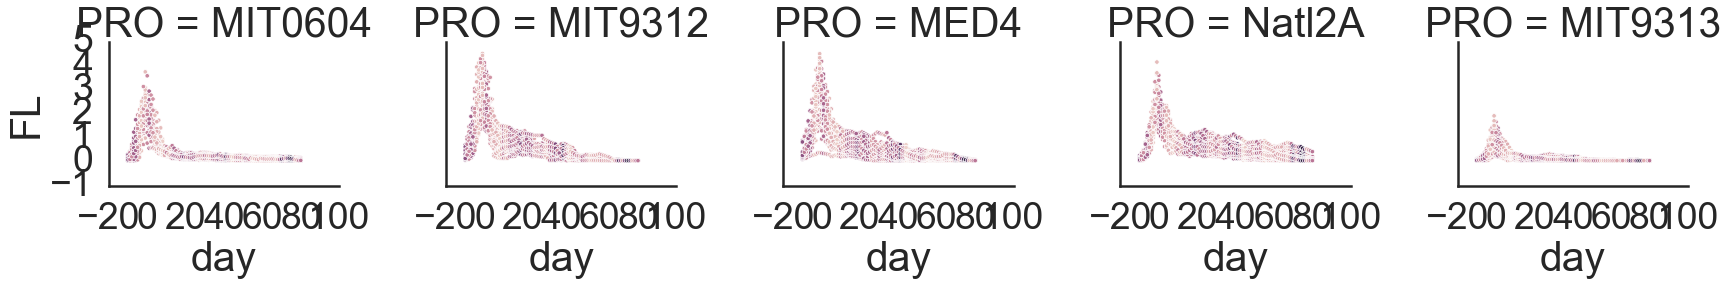

In [118]:
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

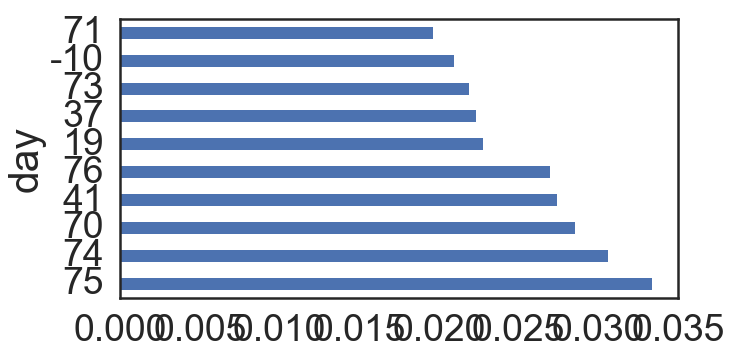

In [119]:
feature_importances1.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,5) )

In [120]:
feature_importances_all34 = pd.DataFrame({
    'day': [v for l in features34_list for v in l],
    'importance' :  [v for l in clf34_list for v in l.feature_importances_ ]
})
feature_importances_all56 = pd.DataFrame({
    'day': [v for l in features56_list for v in l],
    'importance' :  [v for l in clf56_list for v in l.feature_importances_ ]
})
feature_importances_all1 = pd.DataFrame({
    'day': [v for l in features1_list for v in l],
    'importance' :  [v for l in clf1_list for v in l.feature_importances_ ]
})



In [121]:
feature_importances_all34.index

RangeIndex(start=0, stop=2730, step=1)

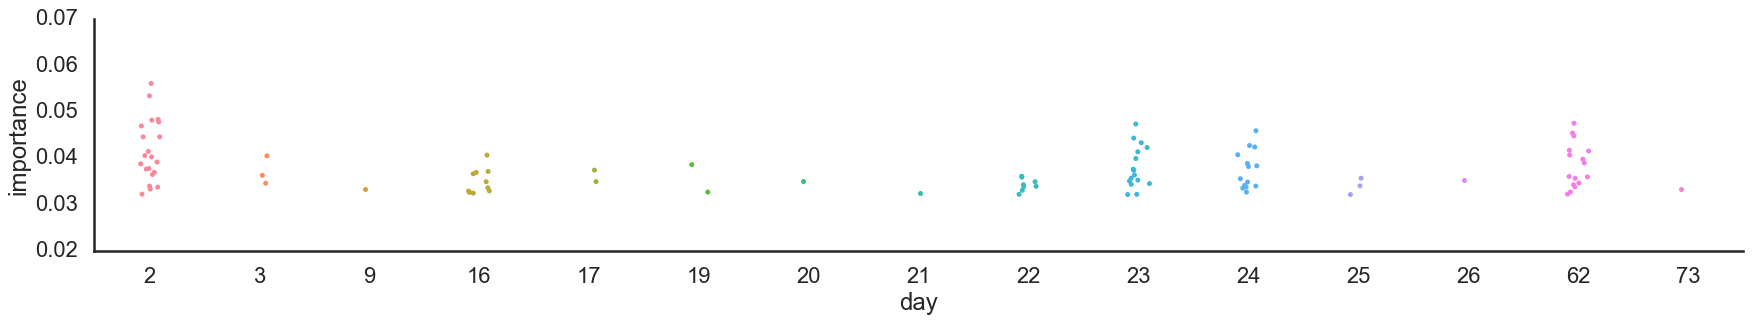

In [60]:
sns.catplot(data=feature_importances_all34.nlargest(columns='importance', n=100), x='day', y='importance',  aspect=5)

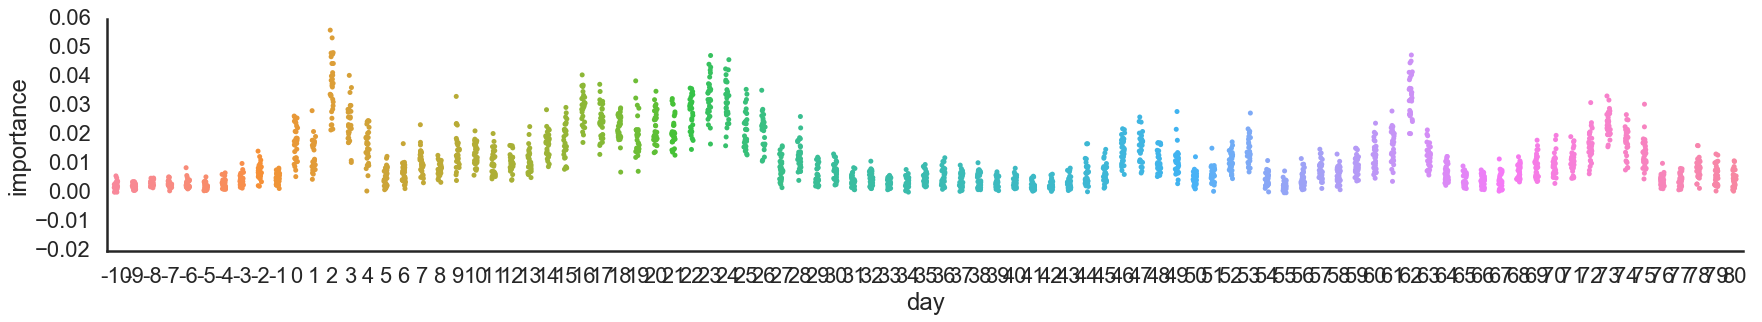

In [61]:
sns.catplot(data=feature_importances_all34, x='day', y='importance',  aspect=5)

Text(0.5,1,'importance per day')

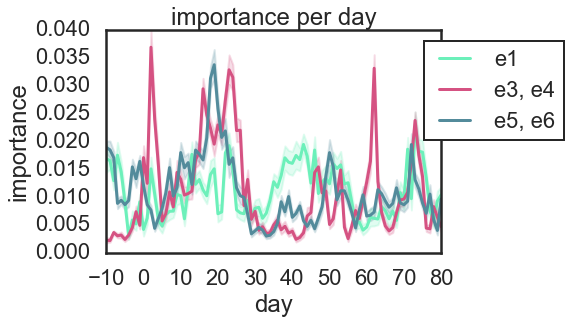

In [62]:
sns.lineplot(data=feature_importances_all1, x='day', y='importance', color=espallete[0],   label='e1', )
sns.lineplot(data=feature_importances_all34, x='day', y='importance', color=espallete[1], label='e3, e4')
sns.lineplot(data=feature_importances_all56, x='day', y='importance', color=espallete[2],  label='e5, e6')
plt.legend(bbox_to_anchor=(1.4,1))
plt.title('importance per day')

In [63]:
feature_importances_all1['experiment'] = 'e1'
feature_importances_all34['experiment'] = 'e3, e4'
feature_importances_all56['experiment'] = 'e5, e6'

feature_importances_all_combined = pd.concat([feature_importances_all1, 
                                              feature_importances_all34, feature_importances_all56])



In [64]:
feature_importances_all_combined.head()

day  importance experiment
0  -10    0.003573         e1
1   -9    0.011772         e1
2   -8    0.010926         e1
3   -7    0.033135         e1
4   -6    0.021374         e1

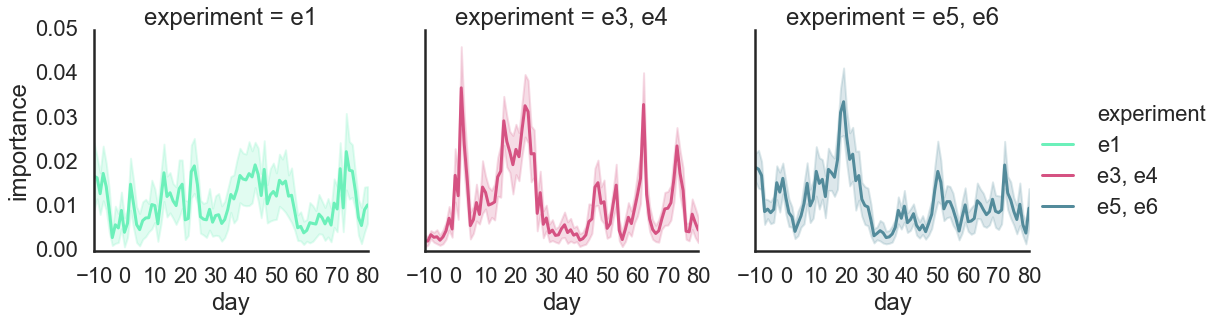

In [65]:
g = sns.relplot(data=feature_importances_all_combined, ci='sd', 
                hue='experiment', palette=espallete,
           y='importance', x='day', col='experiment', kind='line')
#g = sns.relplot(data=feature_importances_all_combined, 
#           y='importance', x='day', col='experiment', ax=g)


In [122]:
all1_days = feature_importances_all1.groupby(['day']).mean().nlargest(10, 'importance').index
all34_days = feature_importances_all34.groupby(['day']).mean().nlargest(10, 'importance').index
all56_days = feature_importances_all56.groupby(['day']).mean().nlargest(10, 'importance').index

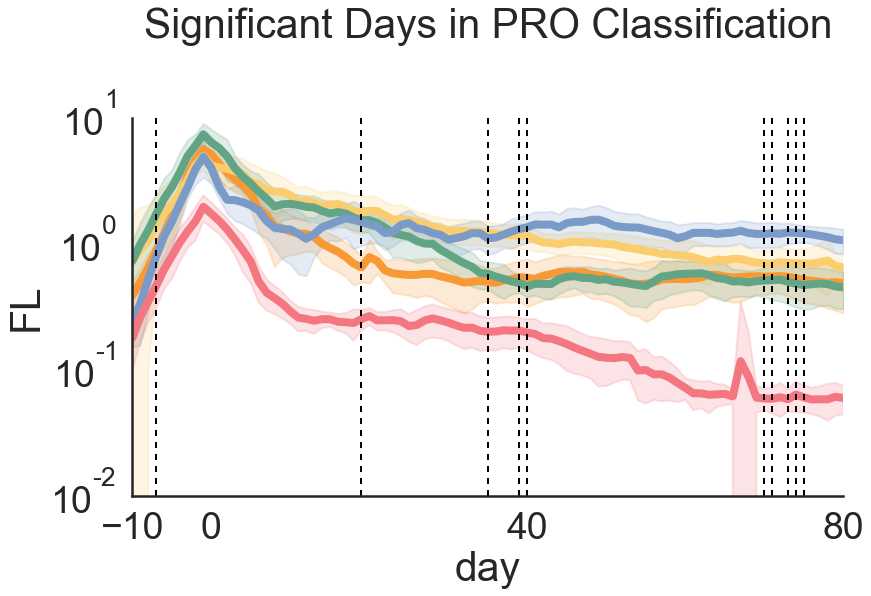

In [134]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds1, #col='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.6,lw=8, height=8,
            x='day', y='FL', kind='line', hue='PRO', legend=False, 
            hue_order=porder, palette=ppallete).set(xticks=[-10, 0, 40, 80])

axes = g.fig.axes
for ax, dlist in zip(axes, [all1_days]) :
    for d in dlist:
        ax.axvline(d, ls='--', lw=2, color='black')
              
plt.title('Significant Days in PRO Classification', y=1.2)            
g.set(yscale='log')
plt.show()


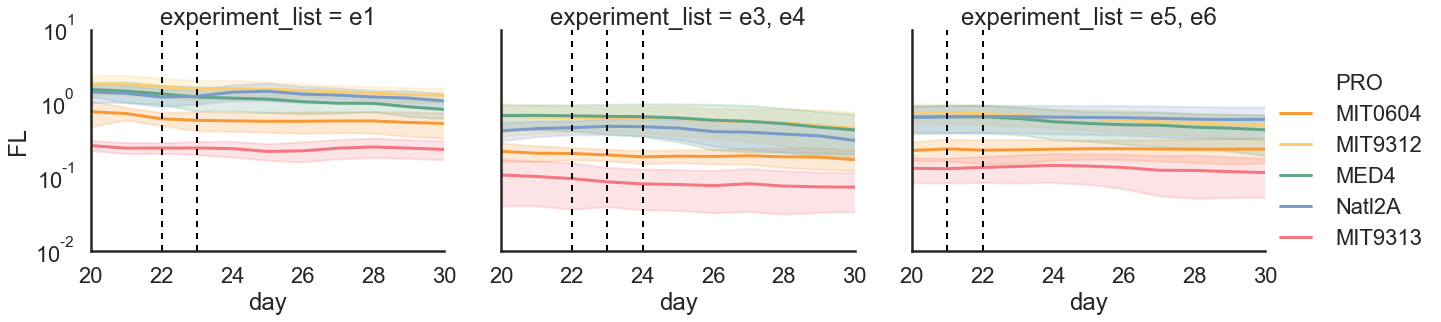

In [68]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, col='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.2,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)

axes = g.fig.axes
for ax, dlist in zip(axes, [all1_days, all34_days, all56_days]) :
    for d in dlist:
        ax.axvline(d, ls='--', lw=2, color='black')
              
g.set(yscale='log')
g.set(xlim=(20,30))
plt.show()


In [69]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day       FL  \
5           e1, 10A         e1    10A  MIT0604  DE  Co_Culture  -10  0.37325   
6           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -9  0.44400   
7           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -8  0.69700   
8           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -7  0.95000   
9           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -6  1.20300   

  experiment_list  decline  
5              e1  0.37325  
6              e1  0.44400  
7              e1  0.69700  
8              e1  0.95000  
9              e1  1.20300

# cluster by decline

## PCA 5 experiments

In [70]:
value_col = 'FL'

In [71]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.72765281 0.11741346]


In [72]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

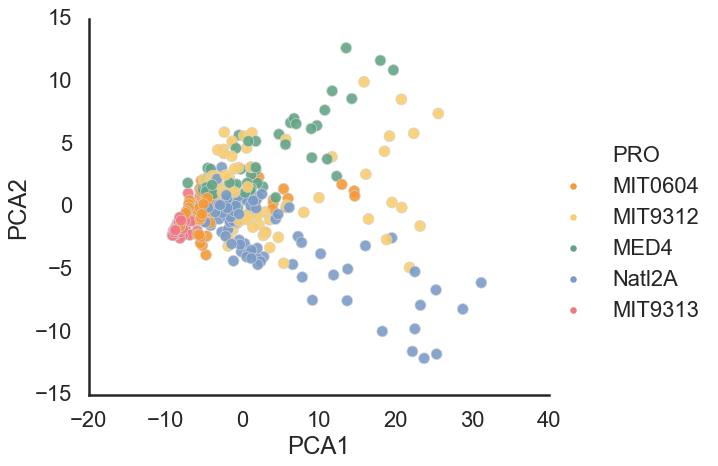

In [73]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

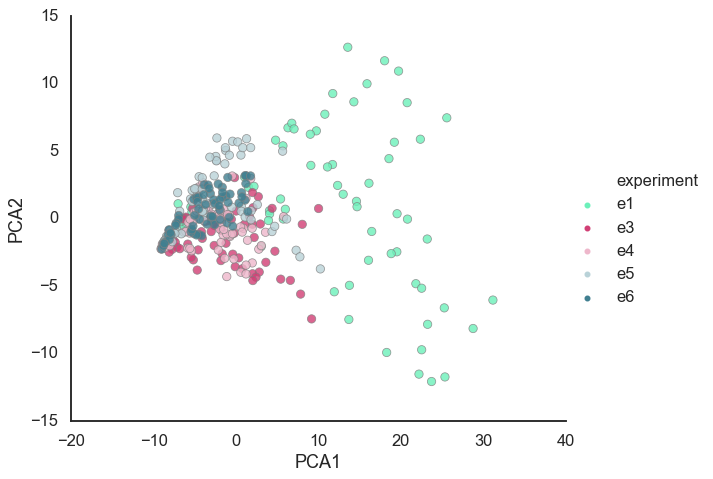

In [74]:
sns.set_context('talk')
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=70, alpha=0.8, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )


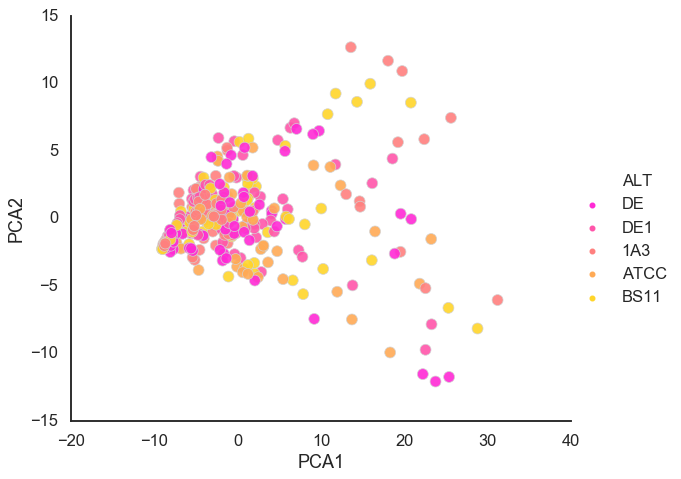

In [75]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

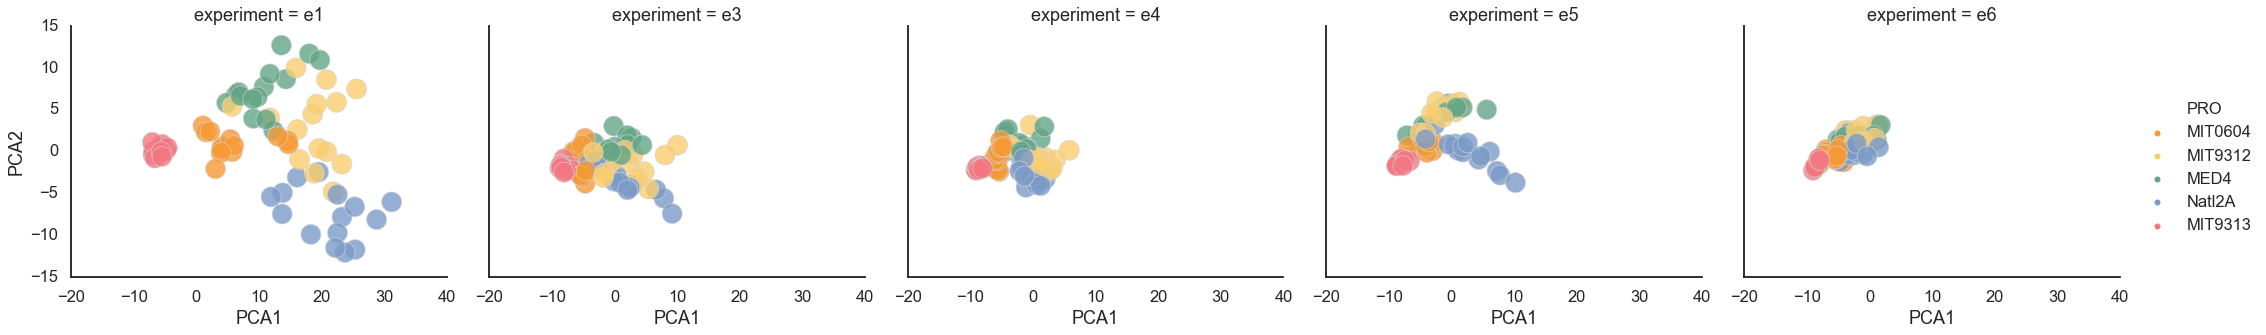

In [76]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

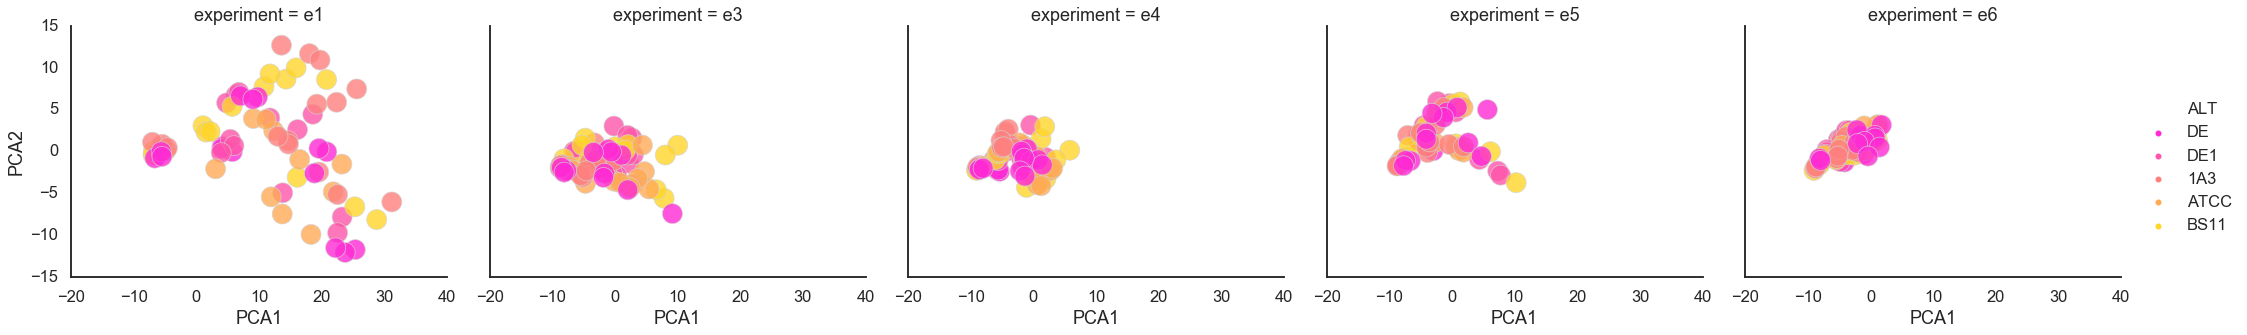

In [77]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

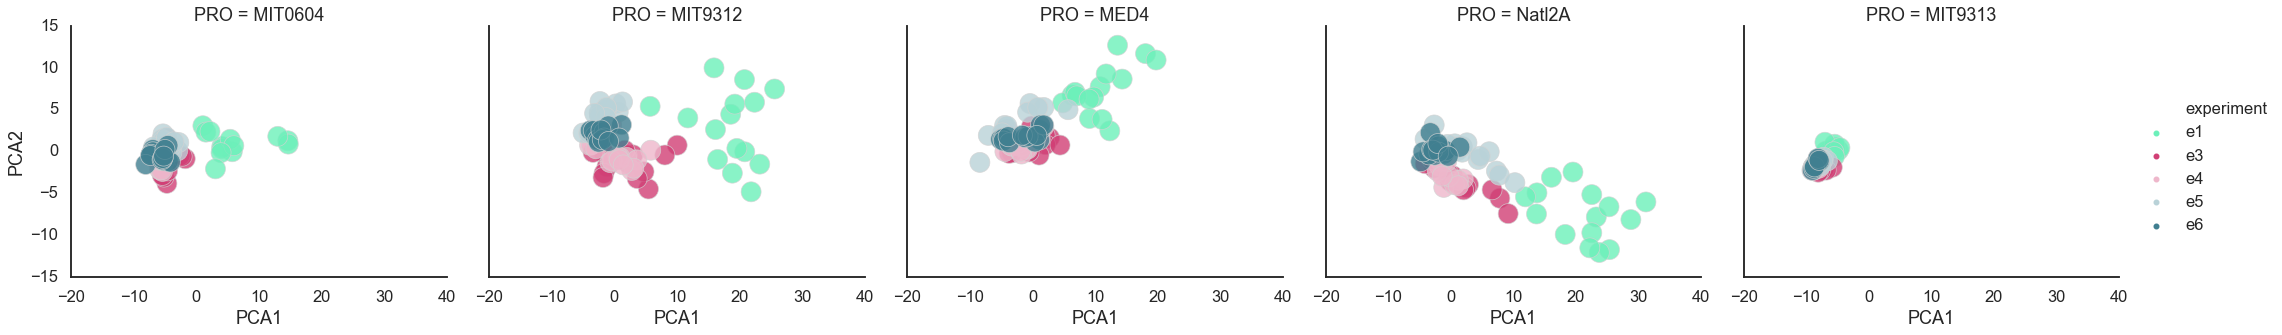

In [78]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [79]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

0.4455379978406868


In [80]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

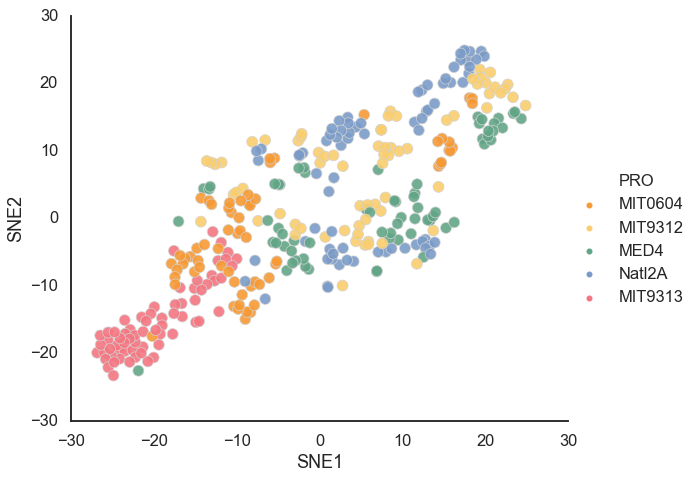

In [81]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

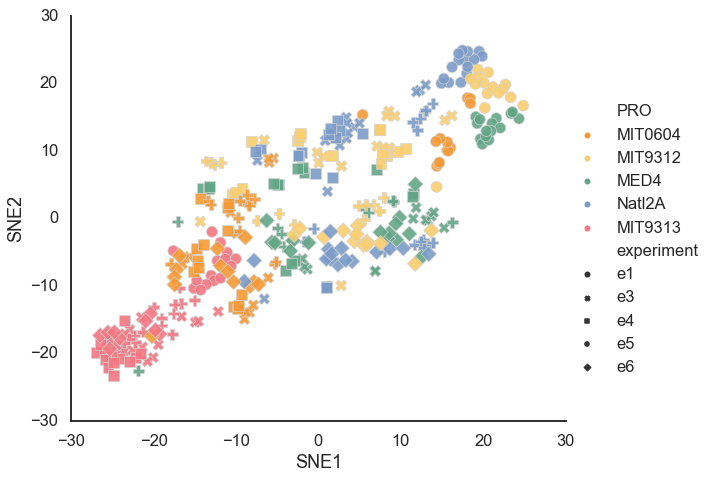

In [82]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            style='experiment',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

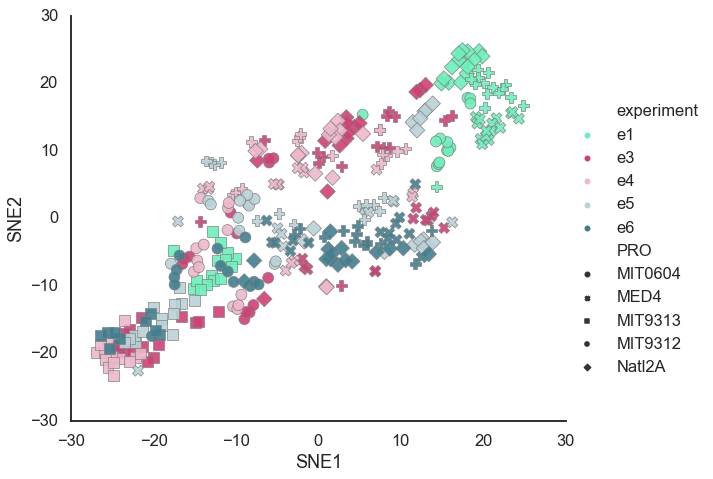

In [83]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            style='PRO',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

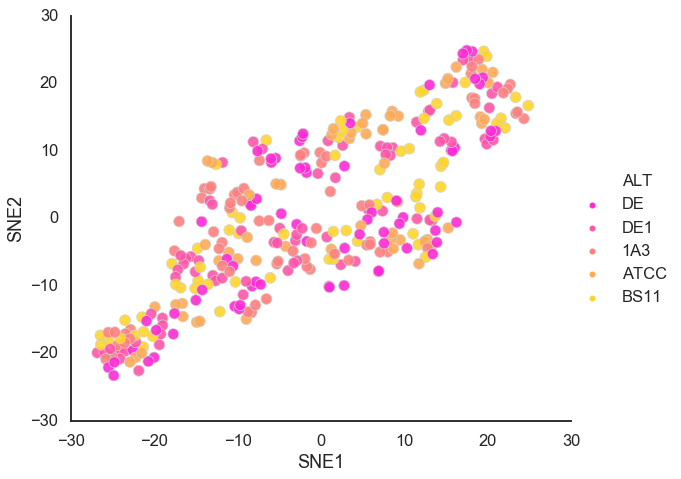

In [84]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

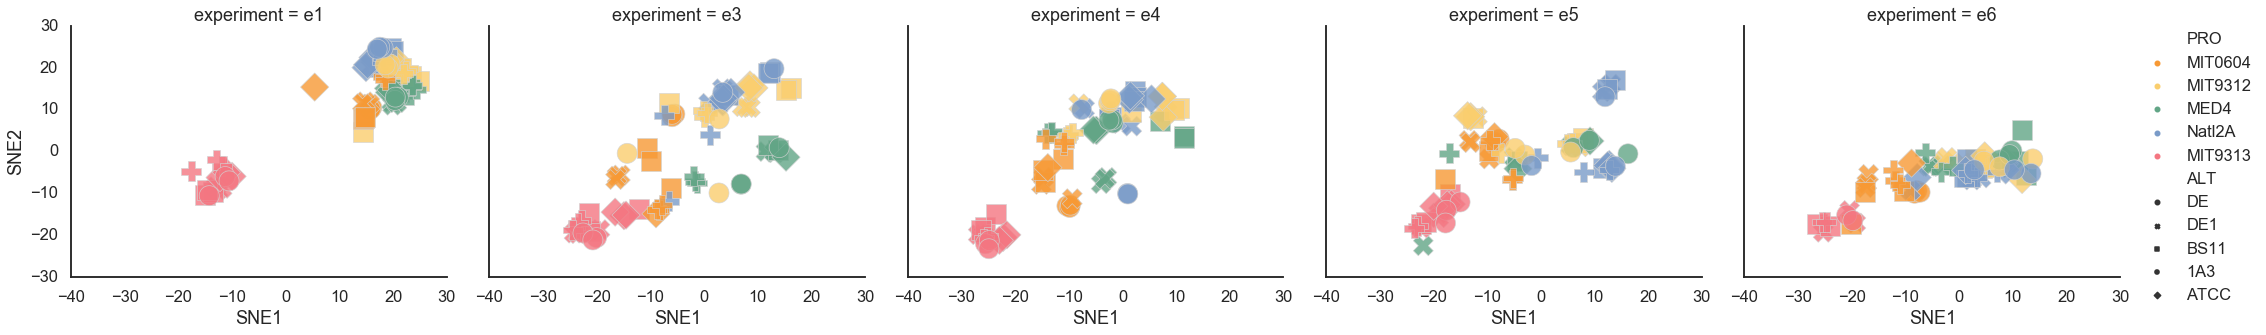

In [85]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

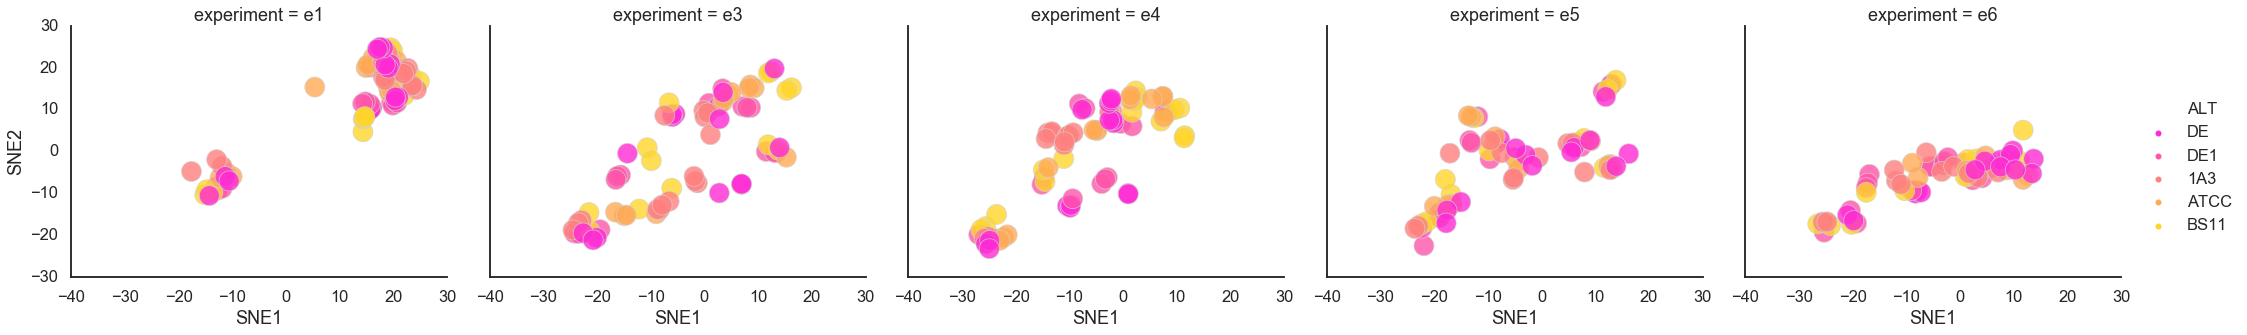

In [86]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

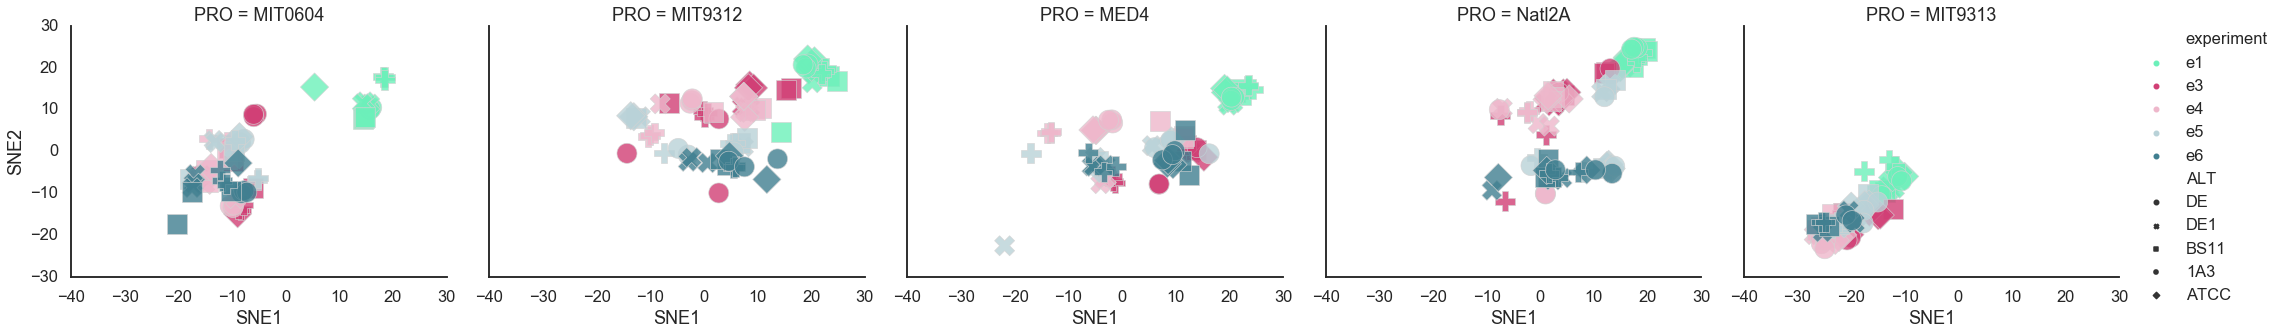

In [87]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 4 experiments

In [88]:
value_col = 'FL'

In [89]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.56457792 0.1723785 ]


In [90]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

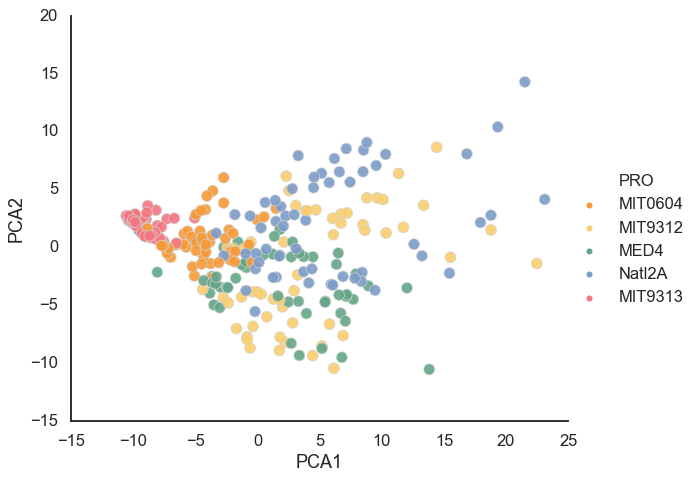

In [91]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

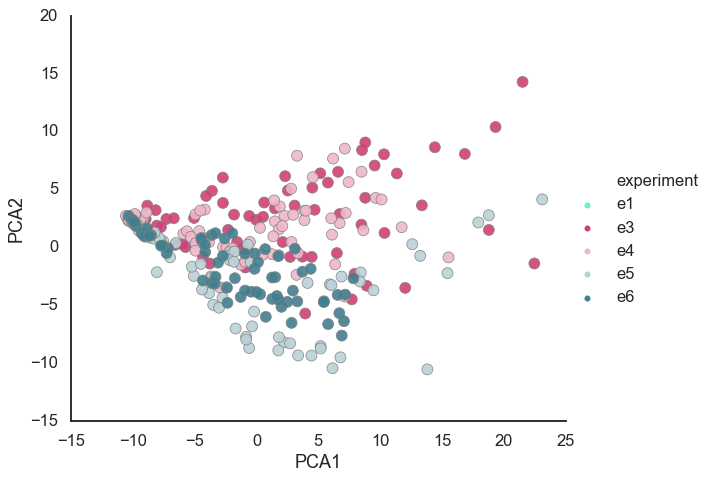

In [92]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

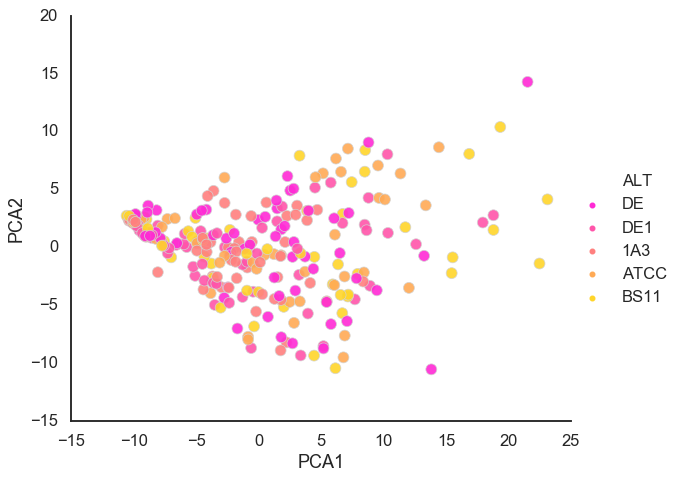

In [93]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

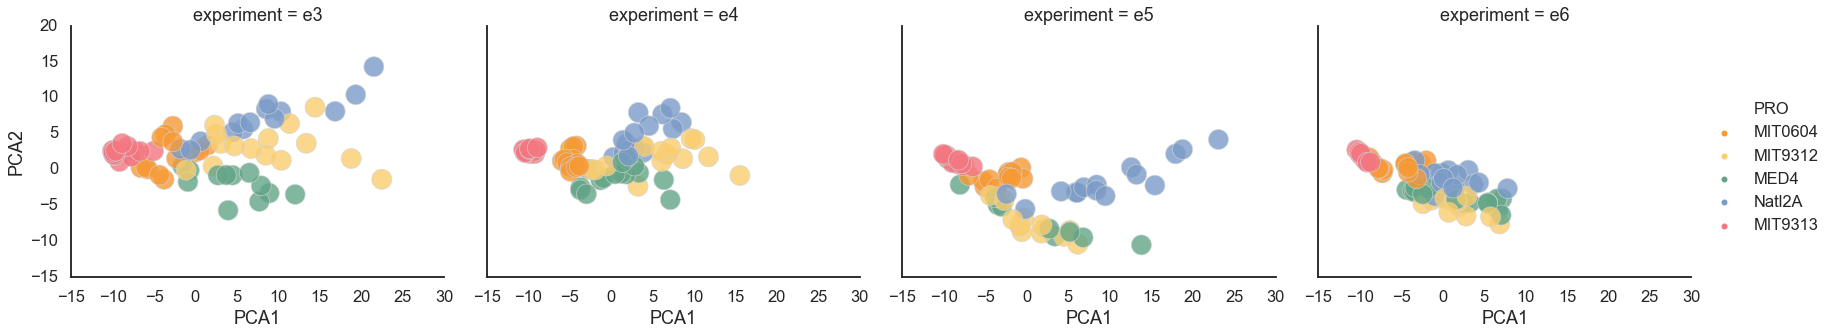

In [94]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

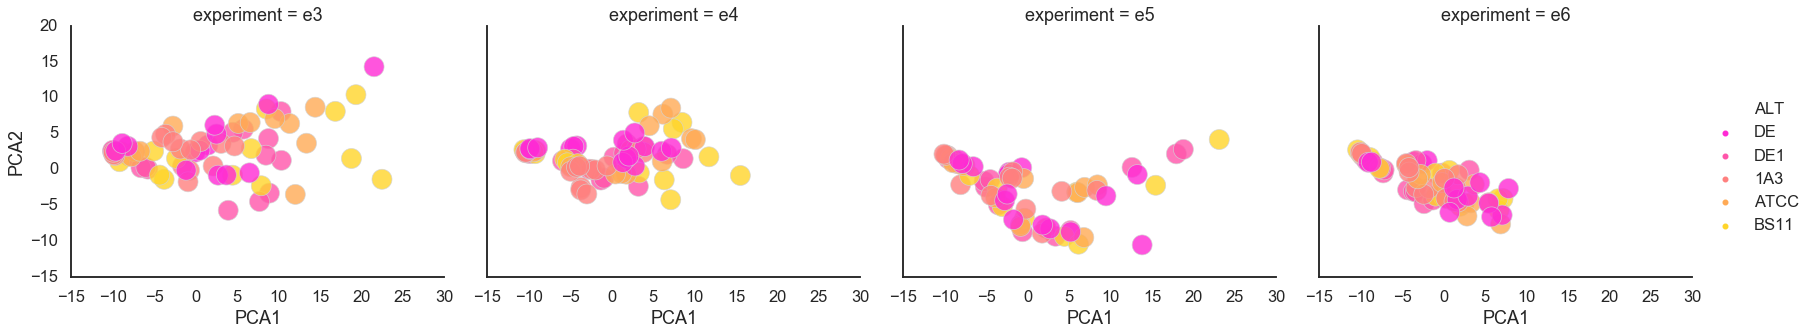

In [95]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

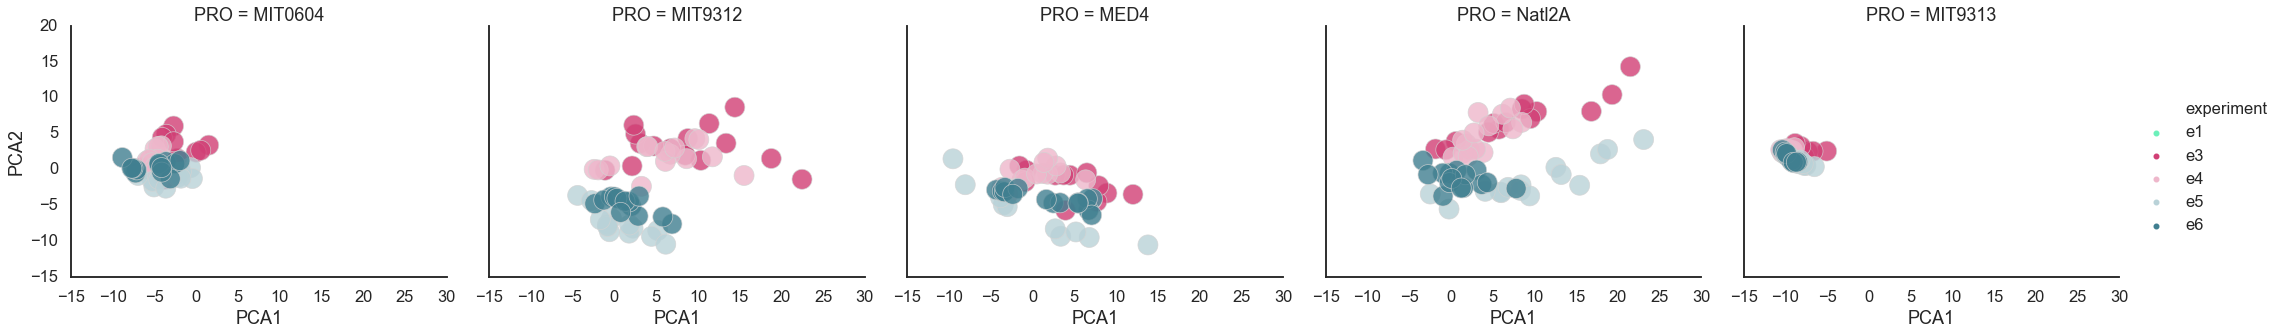

In [96]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [97]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

0.4125943409482511


In [98]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

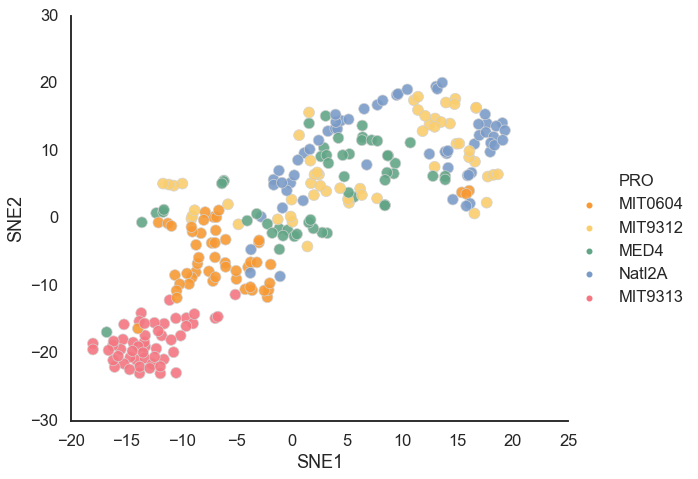

In [99]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

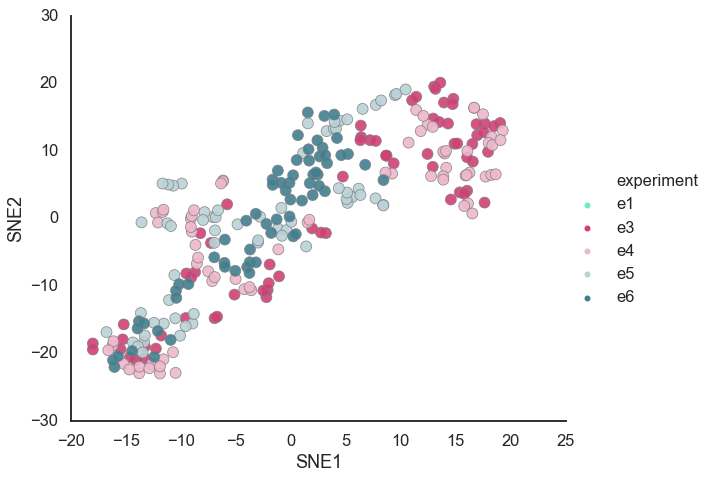

In [100]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

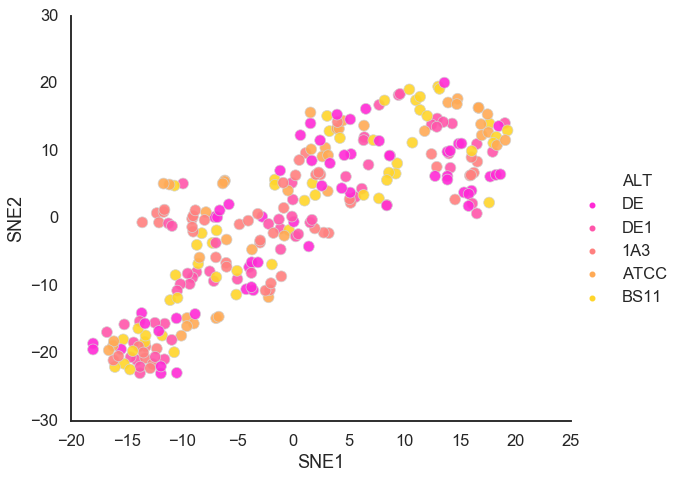

In [101]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

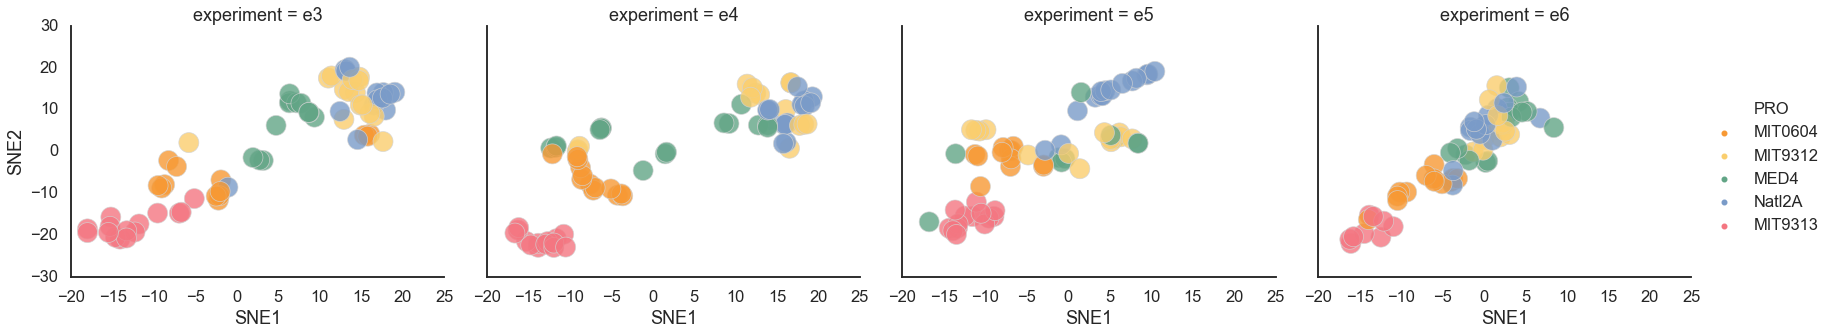

In [102]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

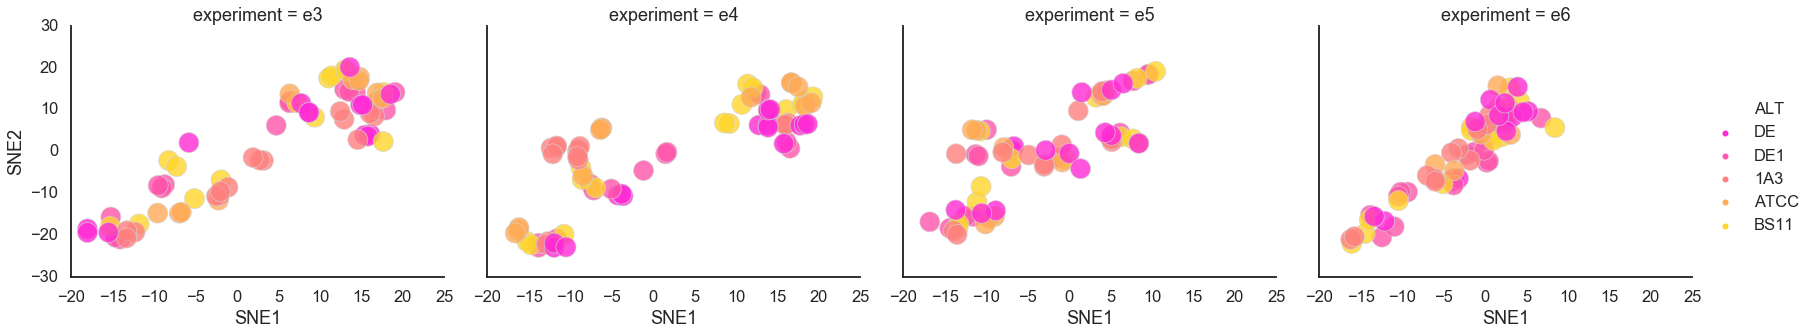

In [103]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

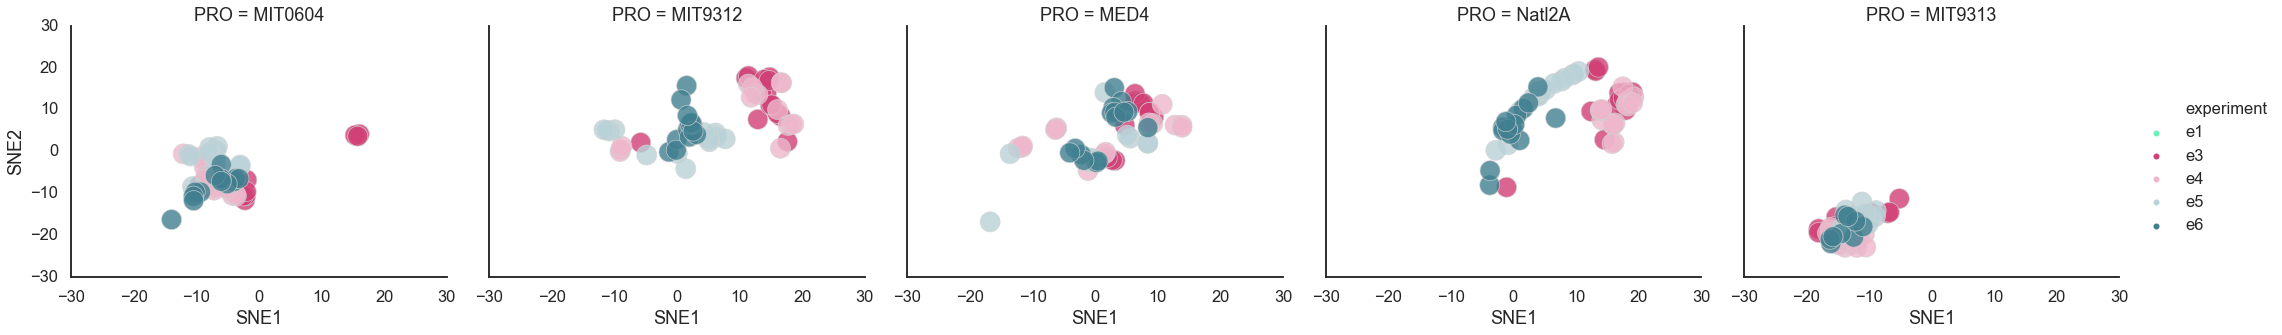

In [104]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 3,4 experiments

In [105]:
value_col = 'FL'

In [106]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.62707758 0.1001848 ]


In [107]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

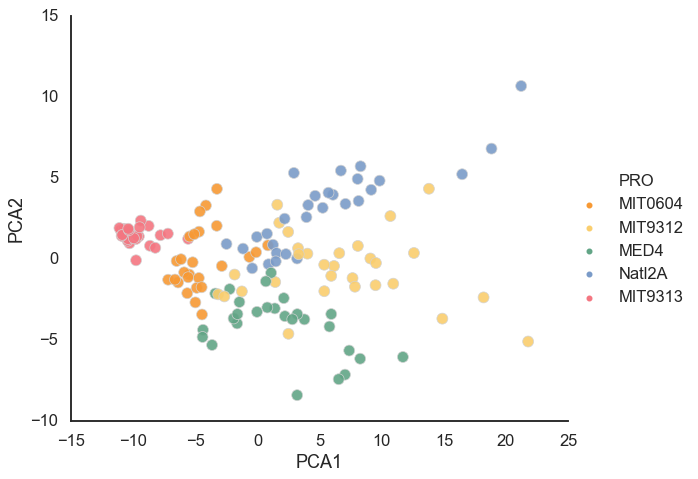

In [108]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

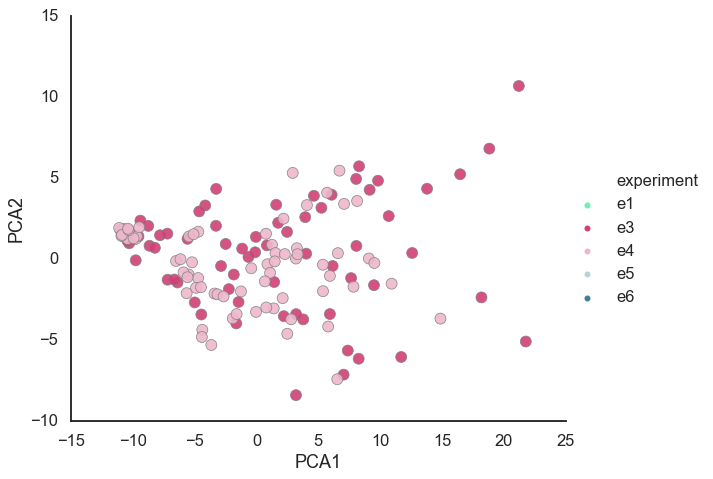

In [109]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

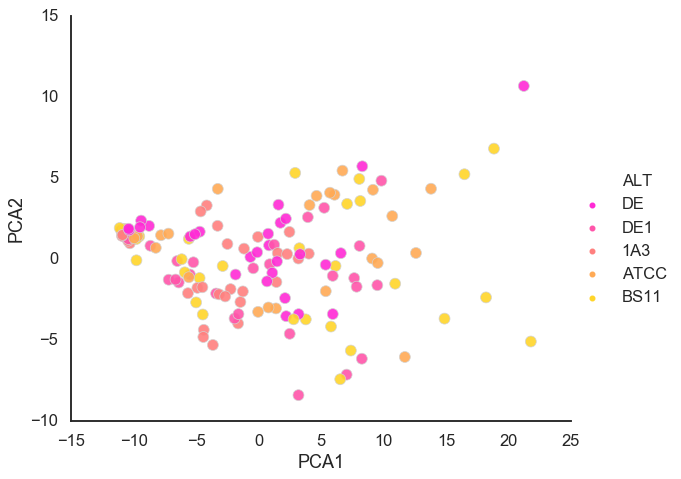

In [110]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

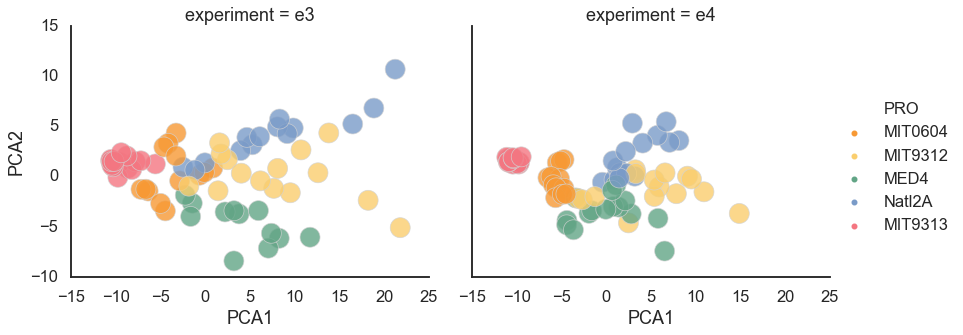

In [111]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

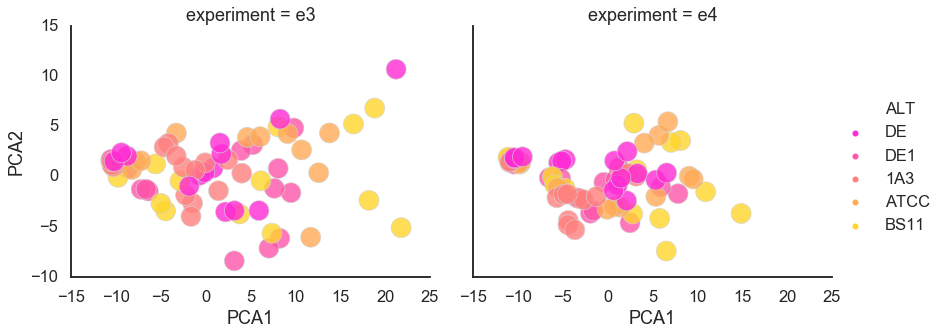

In [112]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

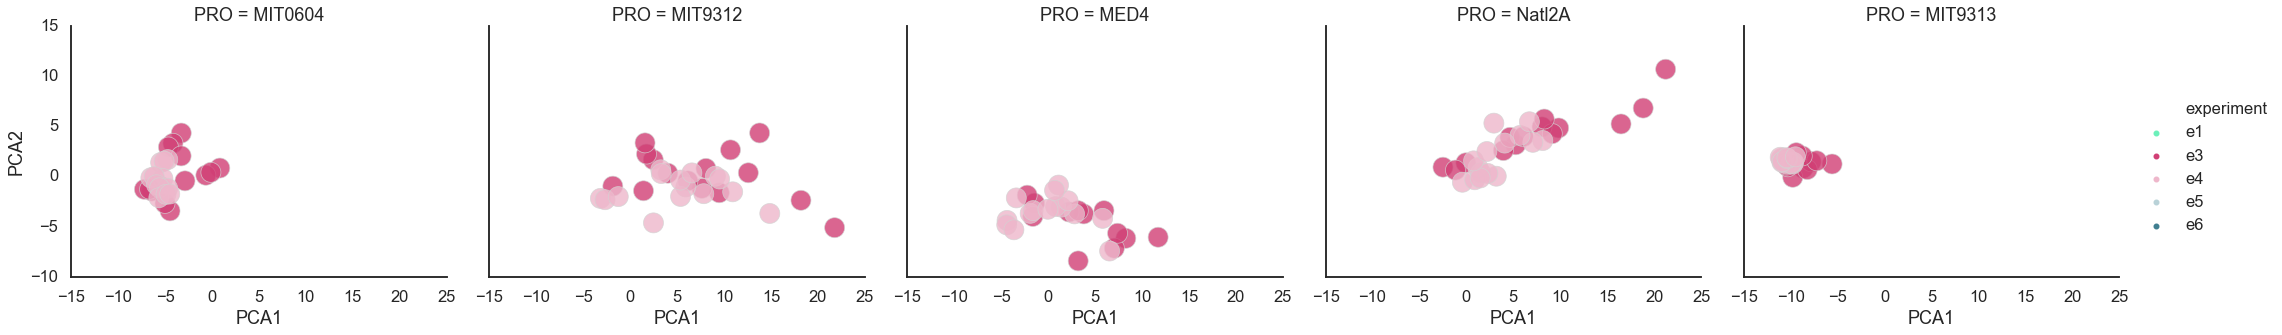

In [113]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [114]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

0.2304958215248052


In [115]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

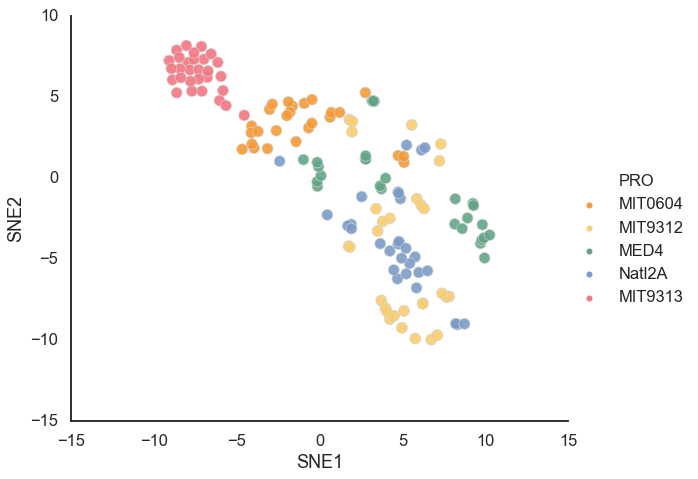

In [116]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

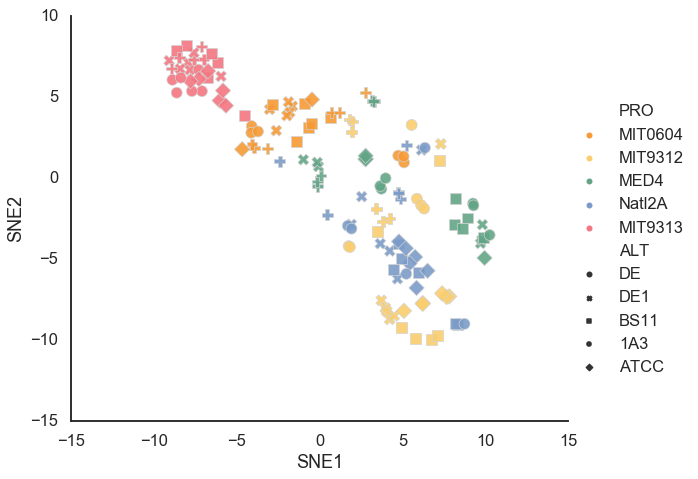

In [117]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

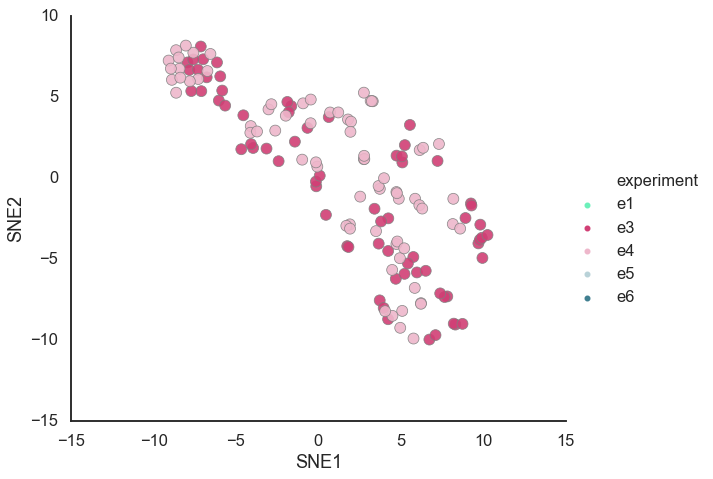

In [118]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

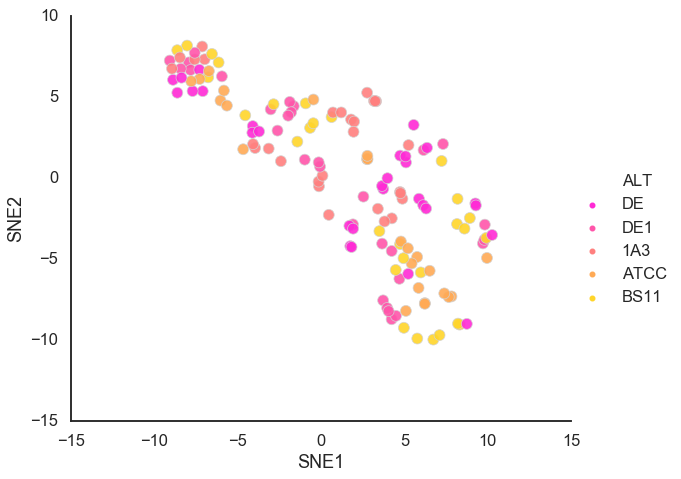

In [119]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

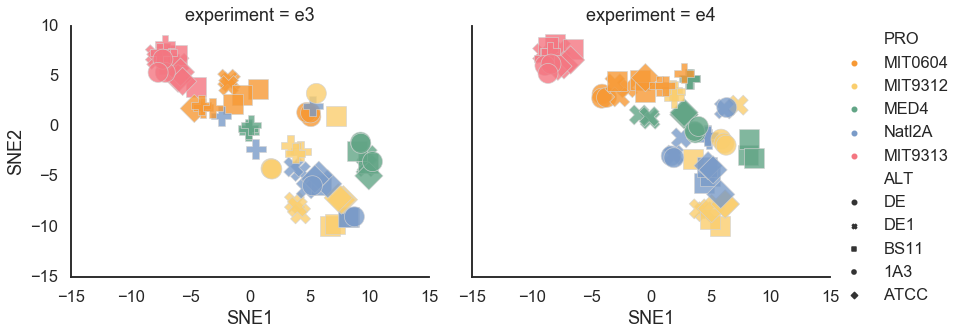

In [120]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

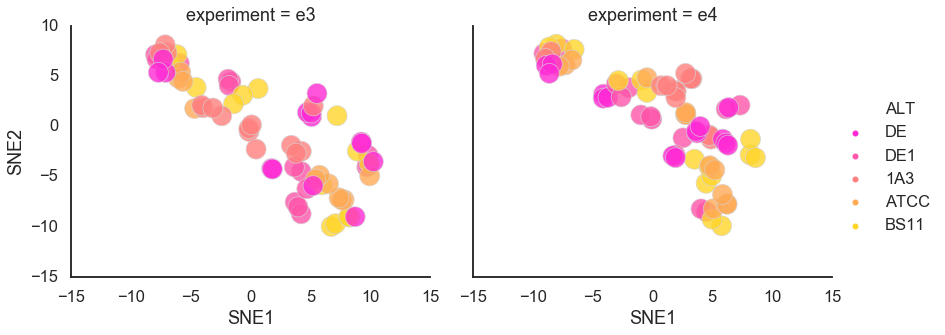

In [121]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

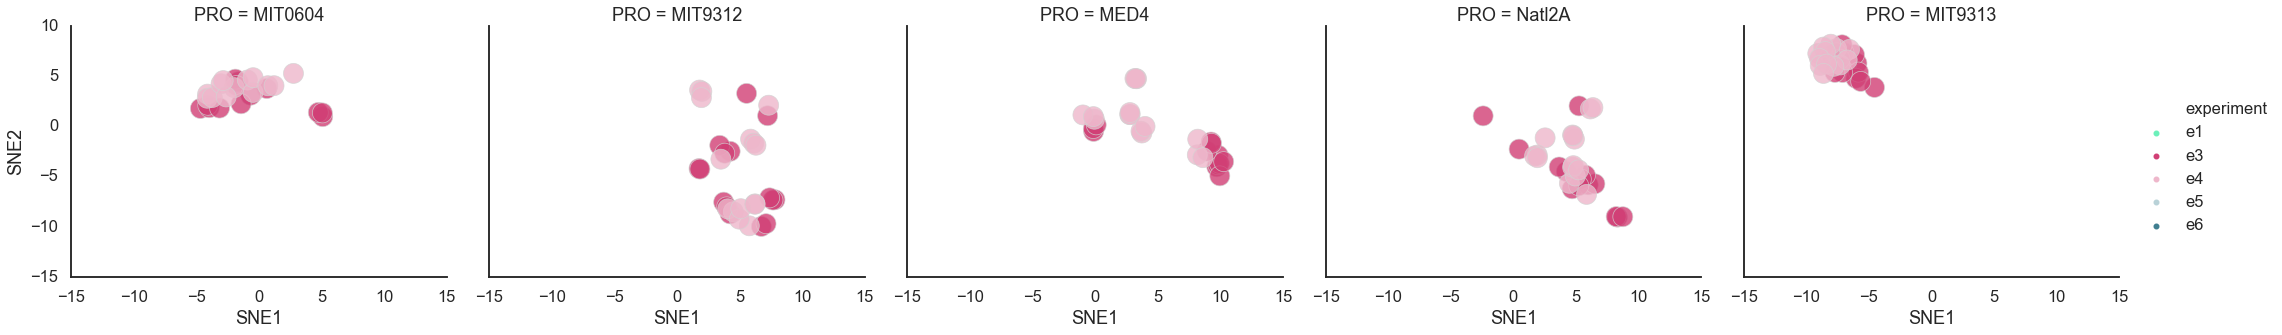

In [122]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

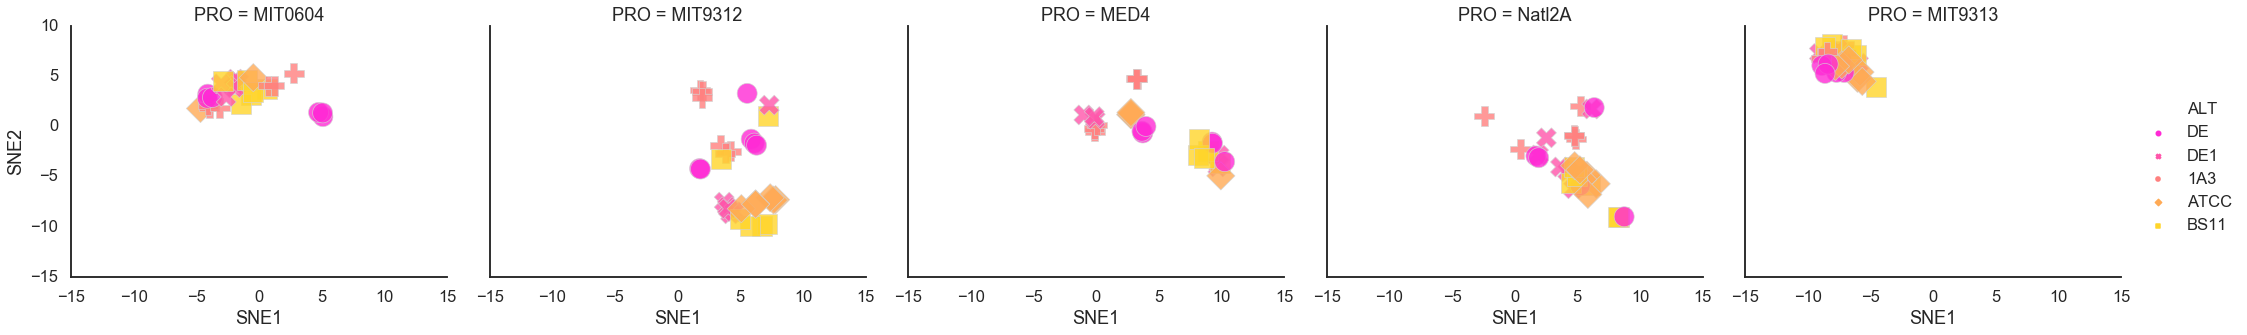

In [123]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# PCA 1 experiments

In [124]:
value_col = 'FL'

In [125]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.66265771 0.17907911]


In [126]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

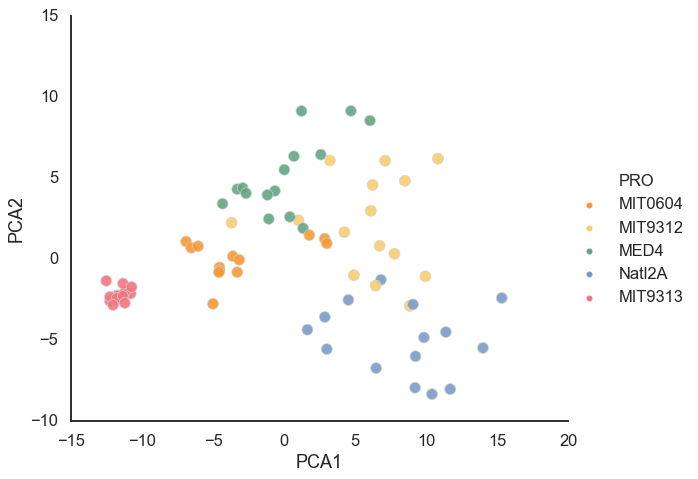

In [127]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

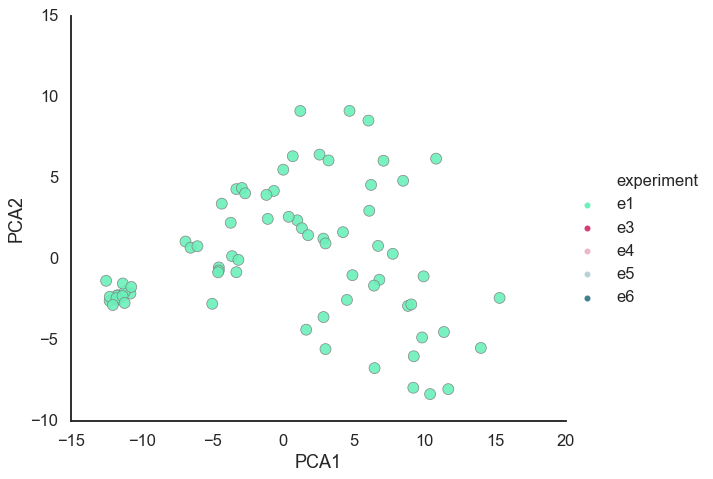

In [128]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

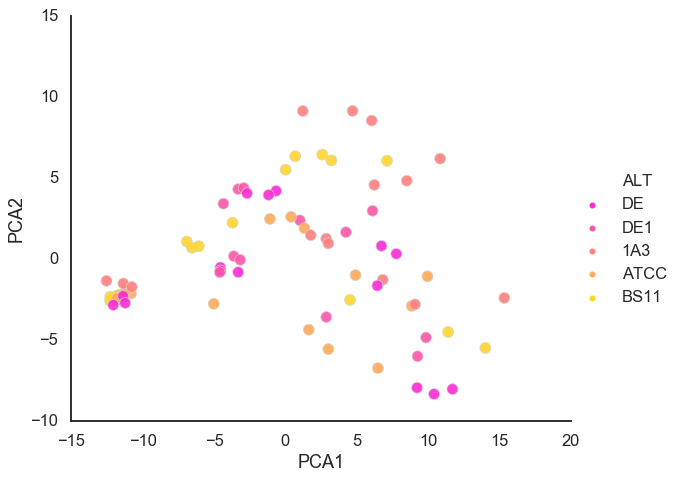

In [129]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

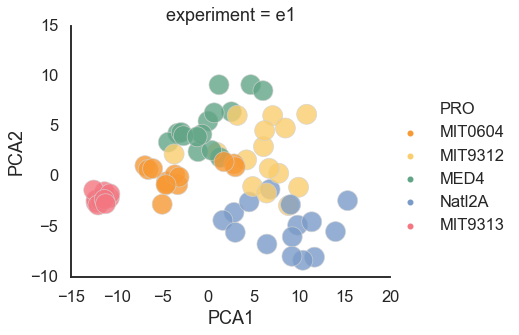

In [130]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

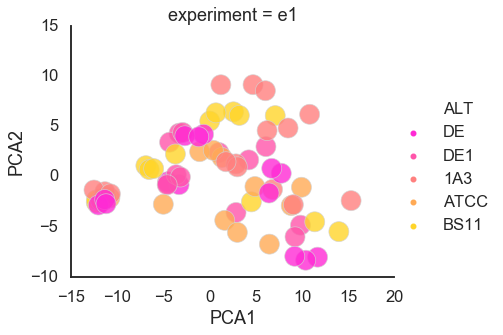

In [131]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

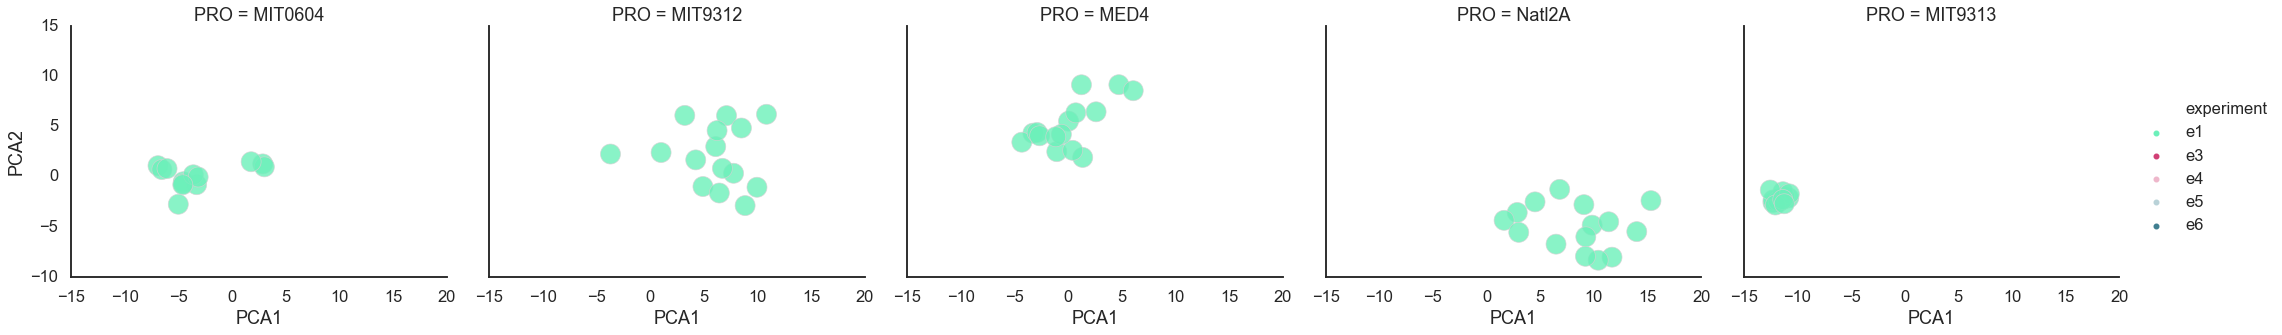

In [132]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [133]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

0.2899846429080294


In [134]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

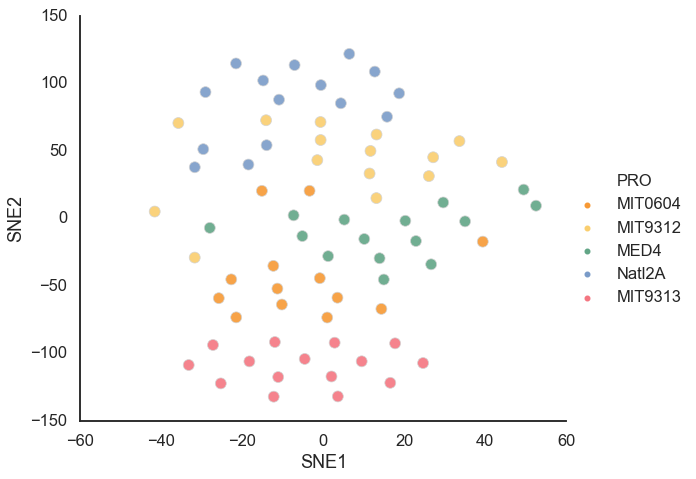

In [135]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

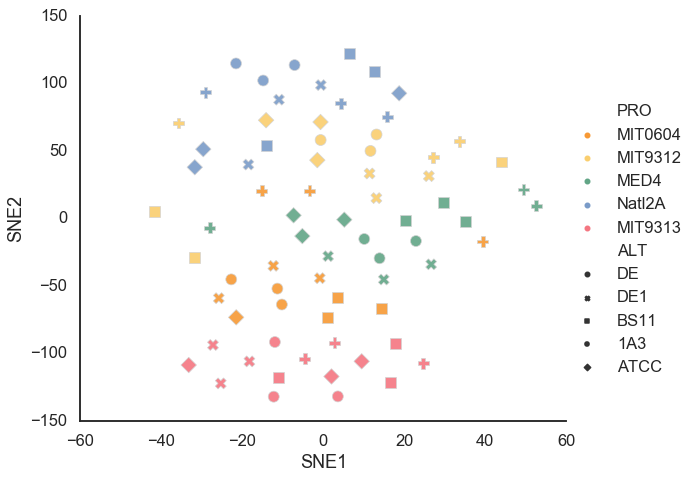

In [136]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

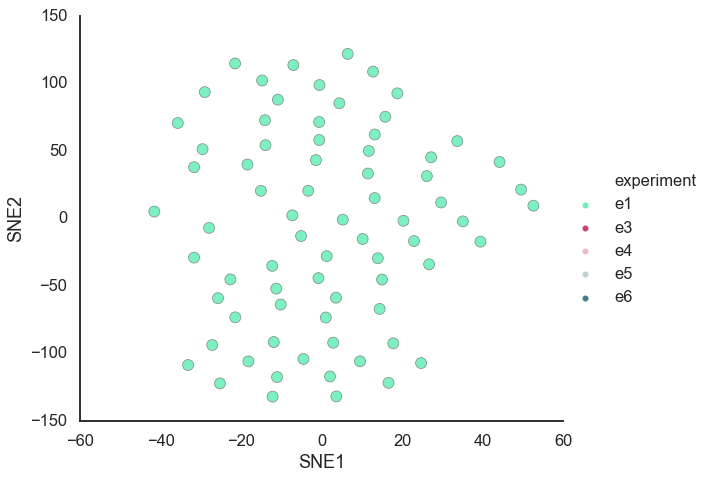

In [137]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

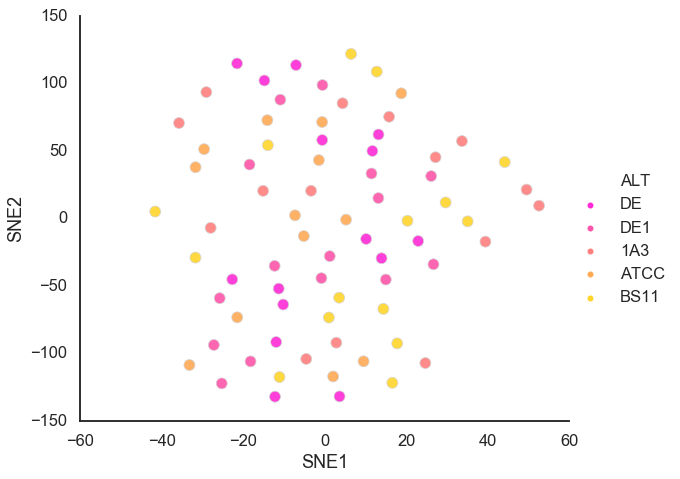

In [138]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

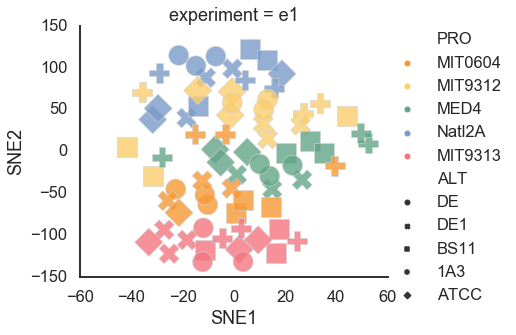

In [139]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

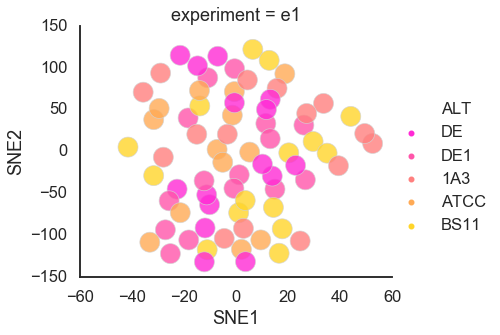

In [140]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

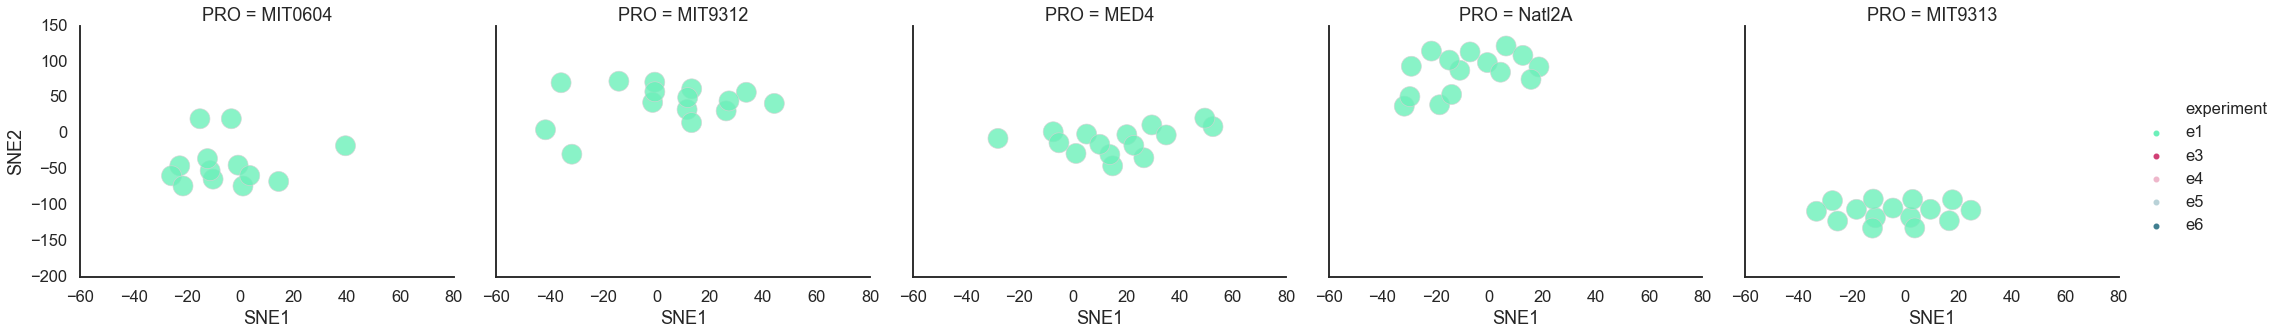

In [141]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

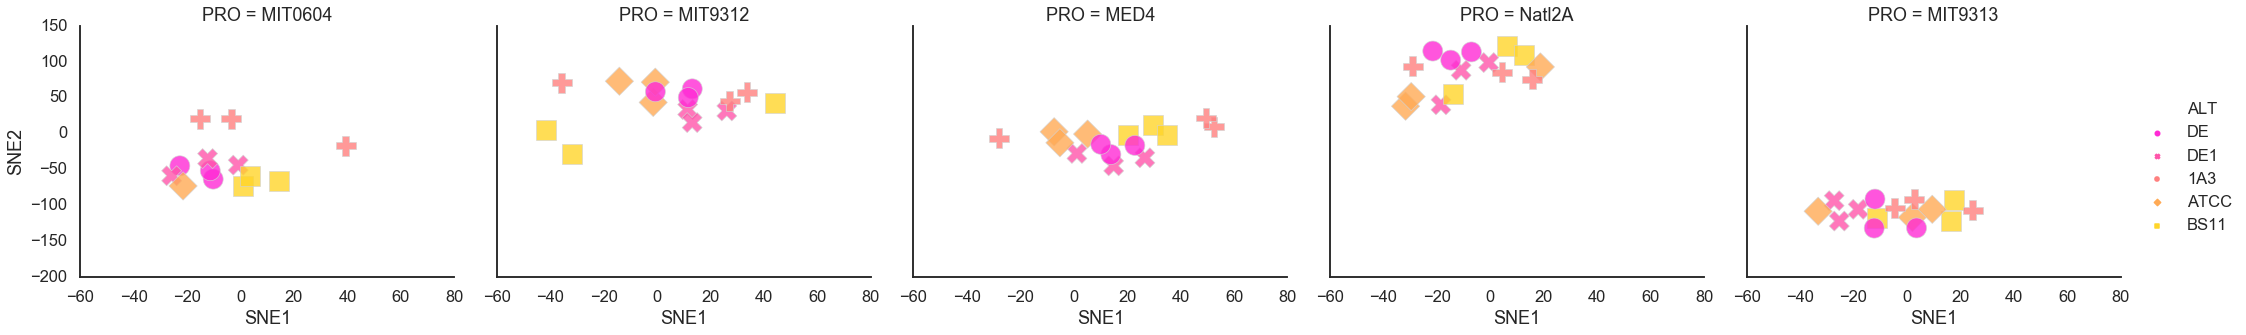

In [142]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# Heatmaps

In [143]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


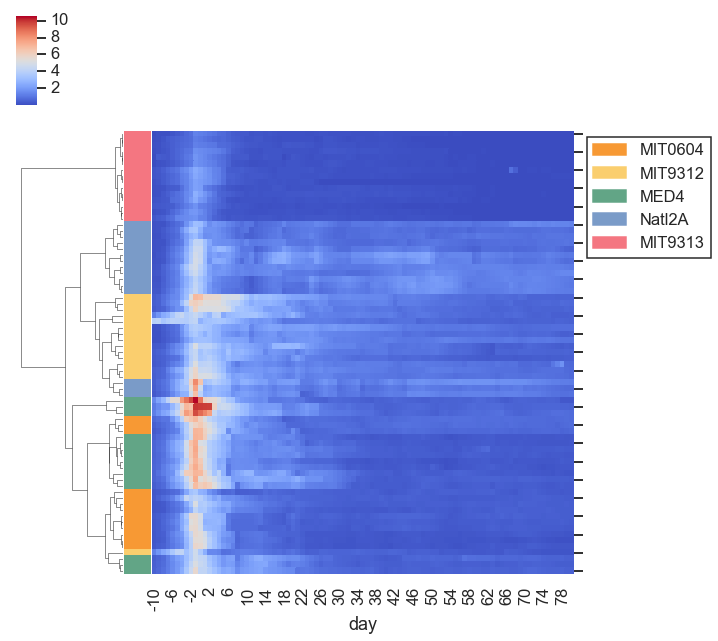

In [144]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

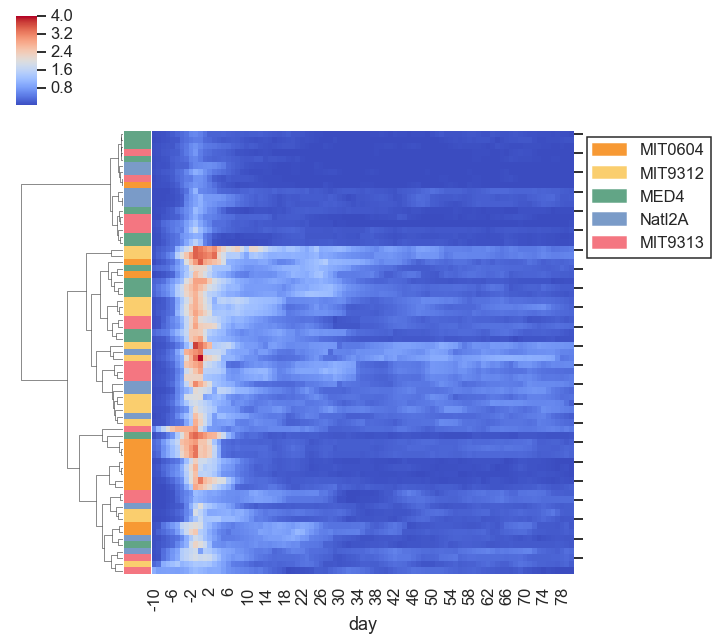

In [145]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

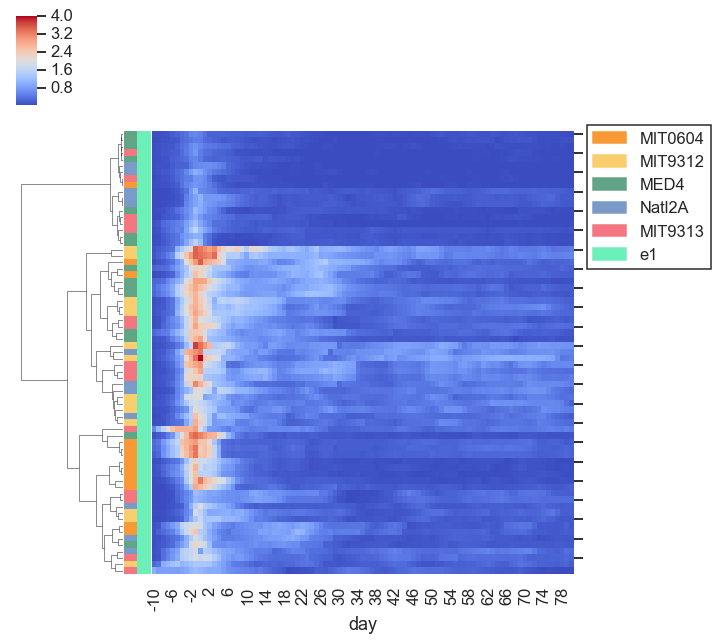

In [146]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

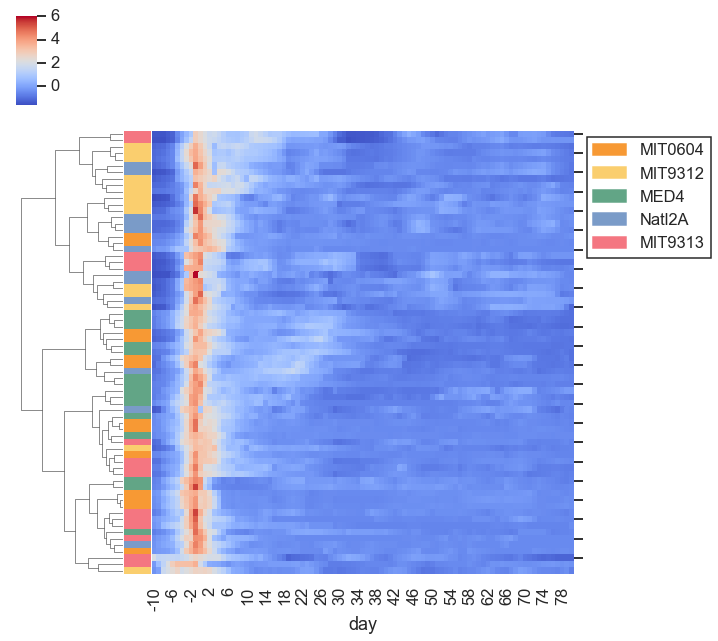

In [147]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [148]:
from sklearn.linear_model import LogisticRegression


In [149]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [150]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [151]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [152]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [153]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\wosnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [154]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [155]:
scores34_df.nlargest(20)

auc                      0.604317
decline_auc              0.589928
decline_logauc           0.589928
decline_log_intercept    0.582734
decline_mean_log         0.582734
decline_max              0.496403
decline_max_log          0.496403
growth_max               0.496403
growth_max_log           0.496403
max                      0.496403
max_log                  0.496403
decline_diff             0.474820
decline_min_log          0.474820
growth_diff              0.460432
decline_half_val         0.446043
decline_log_half_val     0.438849
decline_mean             0.431655
decline_log_tenth_val    0.417266
growth_mean              0.417266
growth_mean_log          0.417266
dtype: float64

In [156]:
scores56_df.nlargest(20)

decline_log_intercept    0.566929
decline_auc              0.519685
decline_mean_log         0.496063
decline_logauc           0.480315
decline_max              0.480315
decline_std              0.480315
growth_max               0.480315
max                      0.480315
decline_diff             0.472441
decline_log_tenth_day    0.472441
growth_diff              0.472441
growth_std               0.472441
decline_half_val         0.456693
growth_auc               0.456693
growth_half_val          0.456693
growth_mean              0.456693
growth_log_intercept     0.448819
growth_log_tenth_val     0.440945
auc                      0.433071
decline_std_log          0.433071
dtype: float64

In [157]:
metadf

experiment_sample experiment sample      PRO  ALT     culture        FL  \
0            e3, 10A         e3    10A  MIT0604   DE  Co_Culture  0.538703   
1            e3, 10B         e3    10B  MIT0604   DE  Co_Culture  0.506254   
2            e3, 10C         e3    10C  MIT0604   DE  Co_Culture  0.516760   
3            e3, 11A         e3    11A     MED4  DE1  Co_Culture  0.740643   
4            e3, 11B         e3    11B     MED4  DE1  Co_Culture  0.650427   
..               ...        ...    ...      ...  ...         ...       ...   
64            e3, 8A         e3     8A  MIT9312   DE  Co_Culture  0.428320   
65            e3, 8B         e3     8B  MIT9312   DE  Co_Culture  0.393481   
66            e3, 8C         e3     8C  MIT9312   DE  Co_Culture  0.415130   
67            e3, 9A         e3     9A   Natl2A   DE  Co_Culture  0.589387   
68            e3, 9C         e3     9C   Natl2A   DE  Co_Culture  0.905158   

   sample_experiment  
0             10A,e3  
1             10B,e3  
2             10C,e3  
3             11A,e3  
4             11B,e3  
..               ...  
64             8A,e3  
65             8B,e3  
66             8C,e3  
67             9A,e3  
68             9C,e3  

[69 rows x 8 columns]